In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')


## Random Forest Model

###  Data Preprocessing and Modeling

In [2]:
# Create output directory
OUTPUT_DIR = "output/modeling"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Read data
df = pd.read_csv('processed_data/ct_integrated_data.csv')
df = df.drop(columns=['Pop15t19', 'Pop20t24', 'Pop25t29'])

# Remove rows with NaN in target variables
print(f"Original number of rows: {len(df)}")
df = df.dropna(subset=['annual_total_crime_density', 'annual_property_crime_density', 'annual_violent_crime_density'])
print(f"Number of rows after removing missing values: {len(df)}")

Original number of rows: 2325
Number of rows after removing missing values: 2325


In [3]:
# 1. Data preprocessing
# Check missing values
print("Missing value statistics:")
print(df.isnull().sum())

# Basic statistical description
print("\nBasic statistical description:")
print(df.describe())

# Check data types
print("\nData types overview:")
print(df.dtypes)

# Handle missing values properly by column type
# For numeric columns - use mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
if df[numeric_cols].isnull().any().any():
    print("Filling missing values in numeric columns...")
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())

# For non-numeric columns - use mode or specific values
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
if df[non_numeric_cols].isnull().any().any():
    print("Filling missing values in non-numeric columns...")
    for col in non_numeric_cols:
        if col in ['geometry']:  # Skip geometry column if present
            continue
        df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown')

Missing value statistics:
GEOID                                  0
Total_Population                       0
Pop15t29                               0
NAME                                   1
income_level                           1
geometry                               0
area_sqkm                              0
population_density                     0
youth_population_pct                   0
station_count                          0
station_density                        0
avg_ridership                          0
transfer_station_ratio                 0
avg_entrances                          0
station_coverage                       0
annual_total_crime_density             0
annual_property_crime_density          0
annual_violent_crime_density           0
poi_density_Transportation Facility    0
poi_density_Recreational Facility      0
poi_density_Education Facility         0
poi_density_Residential                0
poi_density_Social Services            0
poi_density_Religious Instituti

In [4]:
# 2. Feature selection (now including all features as VIF values are acceptable)
# Define target and feature variables
target_vars = ['annual_total_crime_density', 'annual_property_crime_density', 'annual_violent_crime_density']

# Include all features including station_density
features = [
    'station_density', 'station_coverage', 'avg_ridership', 'transfer_station_ratio', 'avg_entrances',
    'income_level', 'poverty_rate', 'population_density', 
    'youth_population_pct', 'road_density', 'neighboring_crime_density',
    'poi_density_Transportation Facility', 'poi_density_Recreational Facility',
    'poi_density_Education Facility', 'poi_density_Residential',
    'poi_density_Social Services', 'poi_density_Religious Institution',
    'poi_density_Cultural Facility', 'poi_density_Public Safety',
    'poi_density_Commercial', 'poi_density_Government Facility',
    'poi_density_Health Services'
]

# Check if all features exist in the dataframe
available_features = [f for f in features if f in df.columns]
if len(available_features) != len(features):
    missing_features = set(features) - set(available_features)
    print(f"\nWarning: Some features are not in the dataframe: {missing_features}")
    features = available_features

print("\nSelected features:")
print(features)

# Create feature matrix and target vectors
X = df[features]
y_total = df[target_vars[0]]
y_property = df[target_vars[1]]
y_violent = df[target_vars[2]]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)



Selected features:
['station_density', 'station_coverage', 'avg_ridership', 'transfer_station_ratio', 'avg_entrances', 'income_level', 'population_density', 'youth_population_pct', 'road_density', 'neighboring_crime_density', 'poi_density_Transportation Facility', 'poi_density_Recreational Facility', 'poi_density_Education Facility', 'poi_density_Residential', 'poi_density_Social Services', 'poi_density_Religious Institution', 'poi_density_Cultural Facility', 'poi_density_Public Safety', 'poi_density_Commercial', 'poi_density_Government Facility', 'poi_density_Health Services']


In [5]:
# 3. Data splitting
X_train, X_test, y_total_train, y_total_test = train_test_split(
    X_scaled_df, y_total, test_size=0.3, random_state=42
)
_, _, y_property_train, y_property_test = train_test_split(
    X_scaled_df, y_property, test_size=0.3, random_state=42
)
_, _, y_violent_train, y_violent_test = train_test_split(
    X_scaled_df, y_violent, test_size=0.3, random_state=42
)

print(f"\nTraining set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (1627, 21), Test set size: (698, 21)


In [6]:
# 4. Model optimization and training with GridSearchCV
def optimize_rf_model(X_train, y_train, X_test, y_test, name):
    """Optimize random forest model using GridSearchCV"""
    
    # Define parameter grid with expanded options
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 15, 25, 35],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }
    
    # Initialize model
    rf = RandomForestRegressor(random_state=42)
    
    # Setup grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    
    # Train model
    print(f"\nOptimizing random forest model for {name}...")
    grid_search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    
    # Use model with best parameters
    best_rf = grid_search.best_estimator_
    
    # Evaluate model on test set
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} - Evaluation metrics on test set:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Cross-validation evaluation
    cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean cross-validation R²: {np.mean(cv_scores):.4f}")
    
    # Save results to text file
    with open(os.path.join(OUTPUT_DIR, f"{name}_model_results.txt"), 'w') as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"R²: {r2:.4f}\n")
        f.write(f"Cross-validation R² scores: {cv_scores}\n")
        f.write(f"Mean cross-validation R²: {np.mean(cv_scores):.4f}\n")
    
    return best_rf, y_pred

# Train and optimize three models
total_model, total_pred = optimize_rf_model(
    X_train, y_total_train, X_test, y_total_test, "total_crime_density"
)

property_model, property_pred = optimize_rf_model(
    X_train, y_property_train, X_test, y_property_test, "property_crime_density"
)

violent_model, violent_pred = optimize_rf_model(
    X_train, y_violent_train, X_test, y_violent_test, "violent_crime_density"
)


Optimizing random forest model for total_crime_density...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
total_crime_density - Evaluation metrics on test set:
MSE: 2998.3154
RMSE: 54.7569
R²: 0.4858
Cross-validation R² scores: [0.53285235 0.58186116 0.39666418 0.56227568 0.41945238]
Mean cross-validation R²: 0.4986

Optimizing random forest model for property_crime_density...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
property_crime_density - Evaluation metrics on test set:
MSE: 2899.7632
RMSE: 53.8494
R²: 0.4436
Cross-validation R² scores: [0.48548887 0.52958006 0.35840872 0.52480921 0.40866352]
Mean cross-validation R²: 0.4614

Optimizing random forest

### Feature Importance Analysis

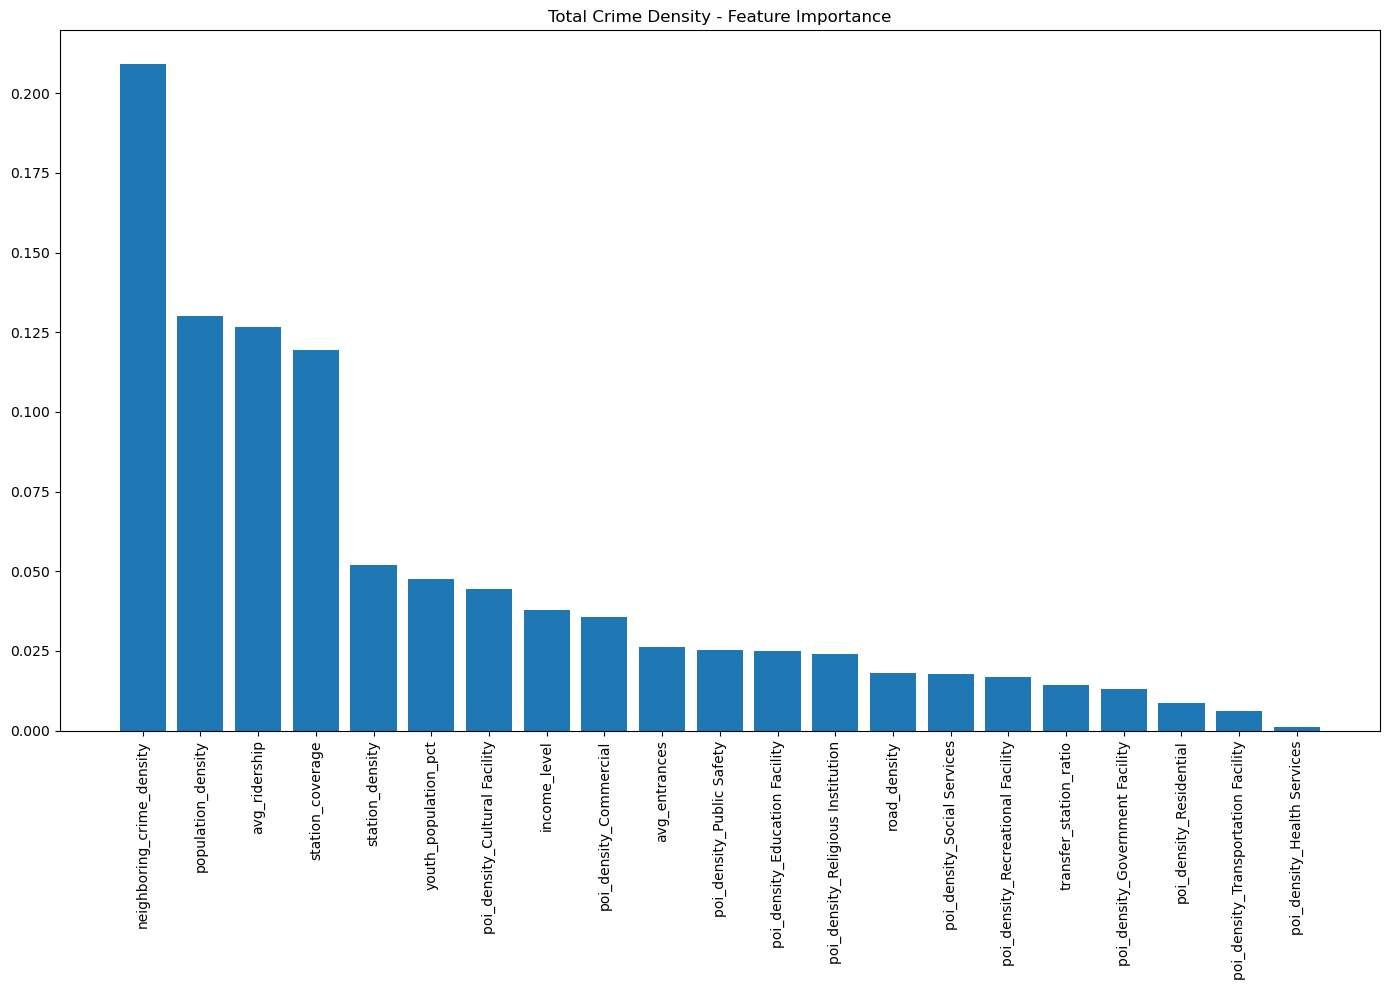


Total Crime Density - Feature Importance - Feature Importance Ranking:
neighboring_crime_density: 0.2093
population_density: 0.1301
avg_ridership: 0.1267
station_coverage: 0.1195
station_density: 0.0518
youth_population_pct: 0.0477
poi_density_Cultural Facility: 0.0443
income_level: 0.0379
poi_density_Commercial: 0.0355
avg_entrances: 0.0263
poi_density_Public Safety: 0.0252
poi_density_Education Facility: 0.0249
poi_density_Religious Institution: 0.0242
road_density: 0.0182
poi_density_Social Services: 0.0178
poi_density_Recreational Facility: 0.0170
transfer_station_ratio: 0.0143
poi_density_Government Facility: 0.0132
poi_density_Residential: 0.0087
poi_density_Transportation Facility: 0.0062
poi_density_Health Services: 0.0010


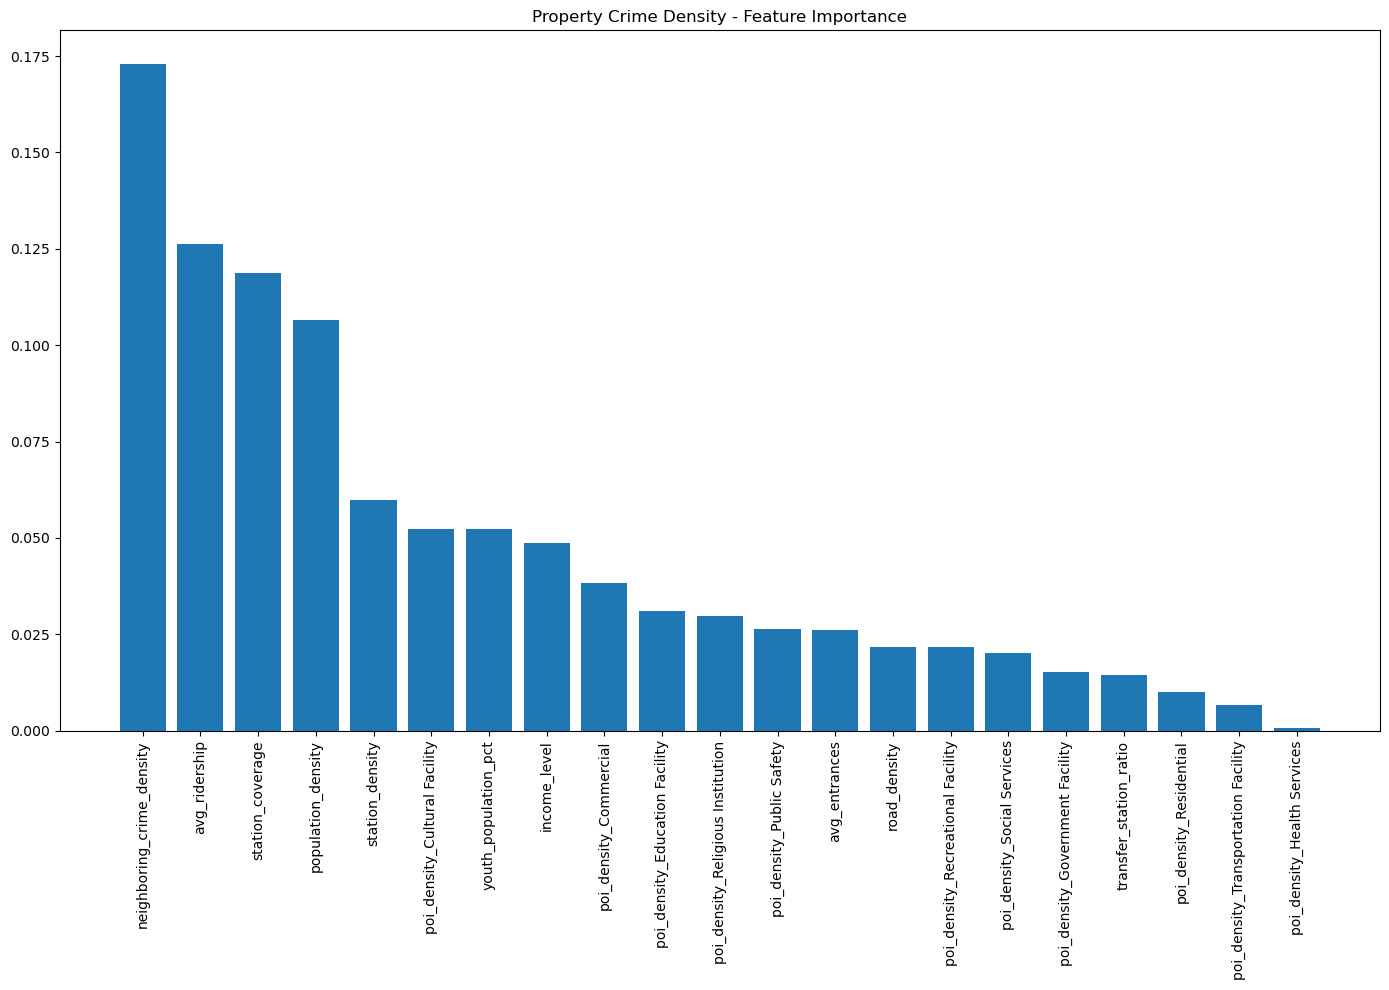


Property Crime Density - Feature Importance - Feature Importance Ranking:
neighboring_crime_density: 0.1730
avg_ridership: 0.1264
station_coverage: 0.1188
population_density: 0.1065
station_density: 0.0599
poi_density_Cultural Facility: 0.0524
youth_population_pct: 0.0522
income_level: 0.0486
poi_density_Commercial: 0.0383
poi_density_Education Facility: 0.0311
poi_density_Religious Institution: 0.0297
poi_density_Public Safety: 0.0263
avg_entrances: 0.0260
road_density: 0.0217
poi_density_Recreational Facility: 0.0216
poi_density_Social Services: 0.0203
poi_density_Government Facility: 0.0151
transfer_station_ratio: 0.0144
poi_density_Residential: 0.0101
poi_density_Transportation Facility: 0.0067
poi_density_Health Services: 0.0008


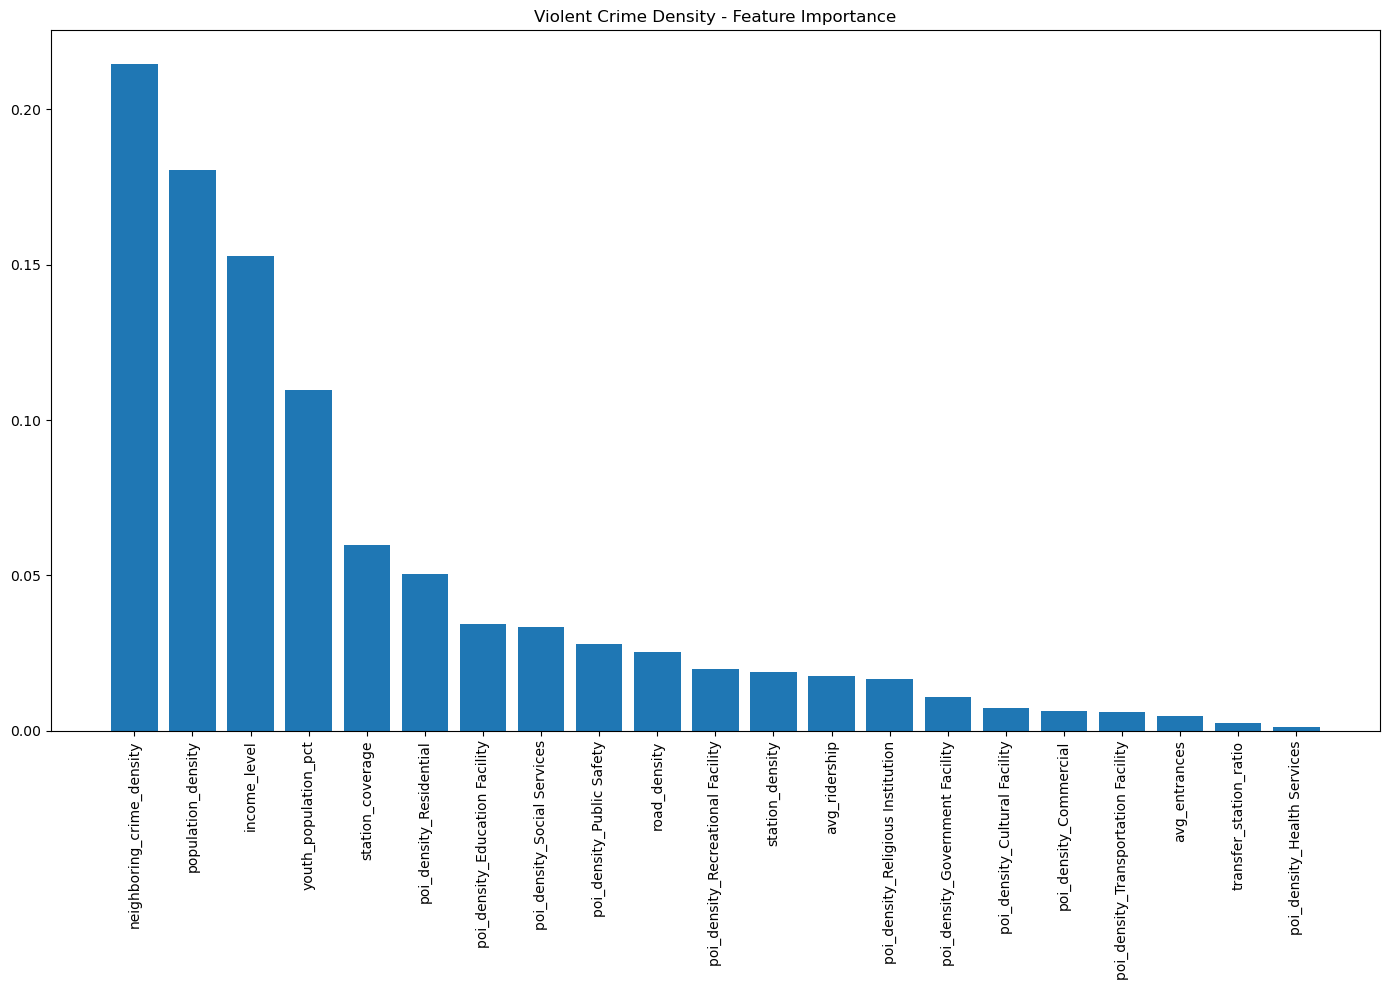


Violent Crime Density - Feature Importance - Feature Importance Ranking:
neighboring_crime_density: 0.2147
population_density: 0.1806
income_level: 0.1527
youth_population_pct: 0.1095
station_coverage: 0.0598
poi_density_Residential: 0.0503
poi_density_Education Facility: 0.0344
poi_density_Social Services: 0.0334
poi_density_Public Safety: 0.0278
road_density: 0.0252
poi_density_Recreational Facility: 0.0199
station_density: 0.0188
avg_ridership: 0.0175
poi_density_Religious Institution: 0.0166
poi_density_Government Facility: 0.0109
poi_density_Cultural Facility: 0.0074
poi_density_Commercial: 0.0062
poi_density_Transportation Facility: 0.0059
avg_entrances: 0.0048
transfer_station_ratio: 0.0023
poi_density_Health Services: 0.0013


In [7]:
# 5. Feature importance analysis
def plot_feature_importance(model, feature_names, title):
    """Plot feature importance"""
    # Get feature importance
    importances = model.feature_importances_
    # Sort indices
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(14, 10))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    
    # Save image and show
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}.png"), dpi=300)
    plt.show()
    
    # Print sorted feature importance
    print(f"\n{title} - Feature Importance Ranking:")
    
    # Save feature importance to text file
    with open(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_importance.txt"), 'w') as f:
        for i in indices:
            importance_str = f"{feature_names[i]}: {importances[i]:.4f}"
            print(importance_str)
            f.write(importance_str + "\n")
    
    return indices, importances

# Plot and print feature importance
total_indices, total_importances = plot_feature_importance(total_model, features, "Total Crime Density - Feature Importance")
property_indices, property_importances = plot_feature_importance(property_model, features, "Property Crime Density - Feature Importance")
violent_indices, violent_importances = plot_feature_importance(violent_model, features, "Violent Crime Density - Feature Importance")


Feature importance difference (Property Crime vs Violent Crime):
Model                                Property Crime Density  \
Feature                                                       
avg_ridership                                      0.126389   
station_coverage                                   0.118779   
poi_density_Cultural Facility                      0.052438   
station_density                                    0.059907   
poi_density_Commercial                             0.038306   
avg_entrances                                      0.026036   
poi_density_Religious Institution                  0.029682   
transfer_station_ratio                             0.014394   
poi_density_Government Facility                    0.015094   
poi_density_Recreational Facility                  0.021604   
poi_density_Transportation Facility                0.006714   
poi_density_Health Services                        0.000814   
poi_density_Public Safety                          0

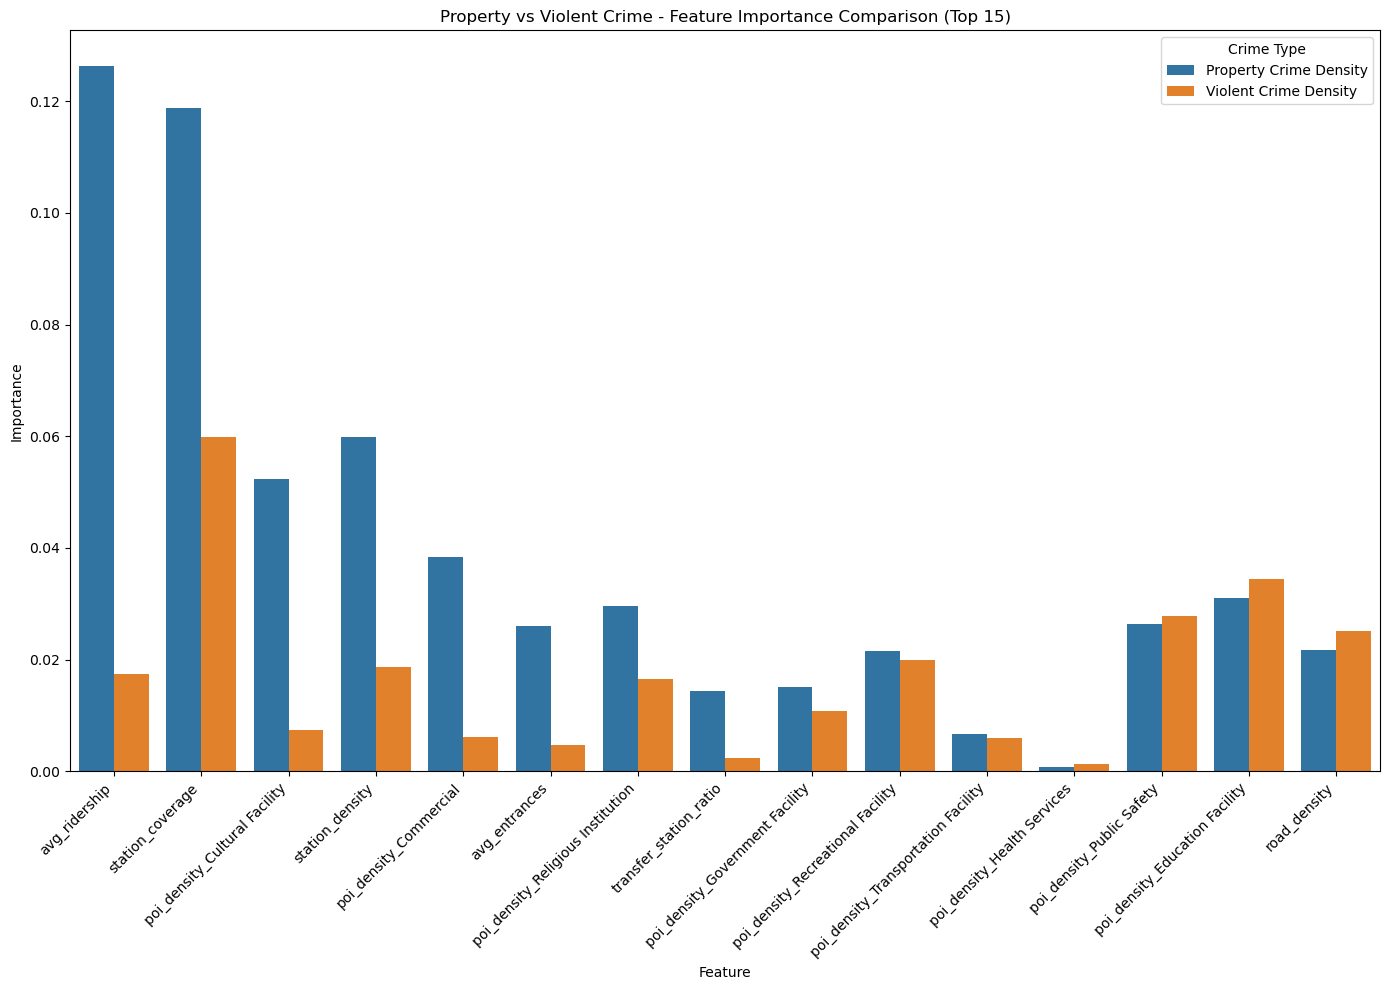

In [8]:
# 5.1 Feature Importance Comparison Across Crime Types
# Compare feature importance differences across different crime-type models
def compare_feature_importance(models, feature_names, model_names):
    """Compare feature importance across different models"""
    # Extract feature importances from each model
    importance_data = []
    
    for model, name in zip(models, model_names):
        importances = model.feature_importances_
        for i, feature in enumerate(feature_names):
            importance_data.append({
                'Model': name,
                'Feature': feature,
                'Importance': importances[i]
            })
    
    # Create a DataFrame
    importance_df = pd.DataFrame(importance_data)
    
    # Pivot for easier comparison
    pivot_df = importance_df.pivot(index='Feature', columns='Model', values='Importance')
    
    # Calculate the difference in importance between property and violent crimes
    pivot_df['Property-Violent_Diff'] = pivot_df[model_names[1]] - pivot_df[model_names[2]]
    
    # Sort by the difference
    sorted_pivot = pivot_df.sort_values(by='Property-Violent_Diff', ascending=False)
    
    print("\nFeature importance difference (Property Crime vs Violent Crime):")
    print(sorted_pivot)
    
    # Save the results
    sorted_pivot.to_csv(os.path.join(OUTPUT_DIR, "crime_type_importance_comparison.csv"))
    
    # Visualization
    plt.figure(figsize=(14, 10))
    
    # Select the top 15 features with the largest difference
    top_features = sorted_pivot.head(15).index
    
    # Prepare data for plotting
    plot_data = []
    for feature in top_features:
        for model_name in model_names[1:3]: # Compare only property and violent crime
            plot_data.append({
                'Feature': feature,
                'Model': model_name,
                'Importance': sorted_pivot.loc[feature, model_name]
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot bar chart
    ax = sns.barplot(x='Feature', y='Importance', hue='Model', data=plot_df)
    plt.title("Property vs Violent Crime - Feature Importance Comparison (Top 15)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Crime Type')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "crime_type_importance_comparison.png"), dpi=300)
    plt.show()

# Execute feature importance comparison across crime types
model_names = ['Total Crime Density', 'Property Crime Density', 'Violent Crime Density']
models = [total_model, property_model, violent_model]
compare_feature_importance(models, features, model_names)

### SHAP Analysis

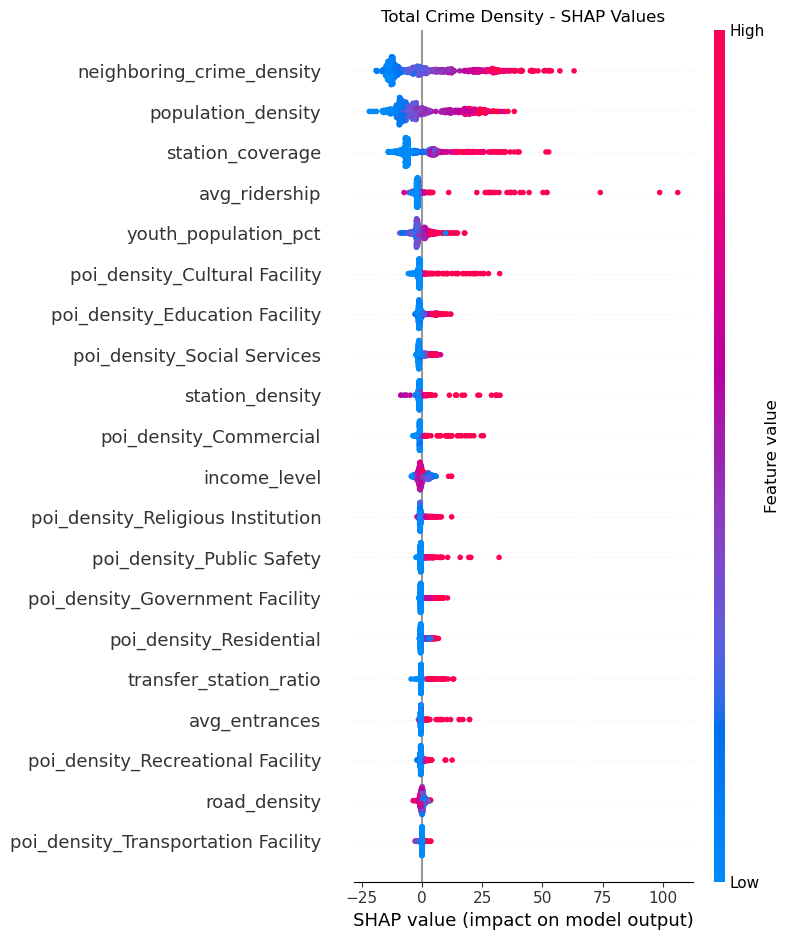

<Figure size 1200x800 with 0 Axes>

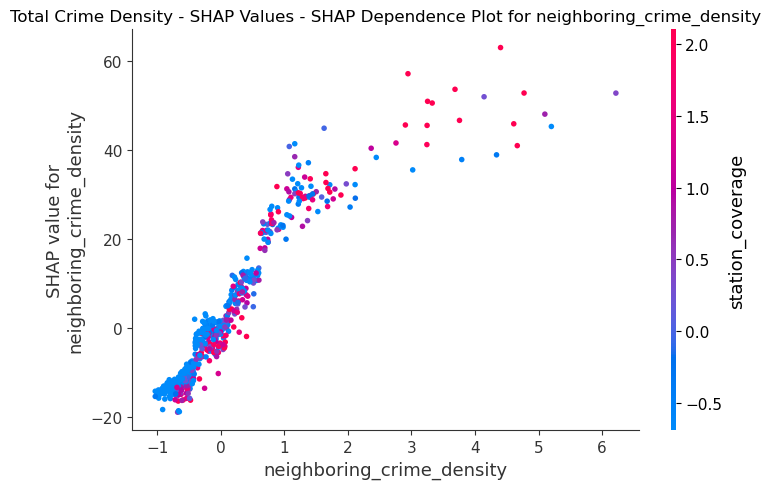

<Figure size 1200x800 with 0 Axes>

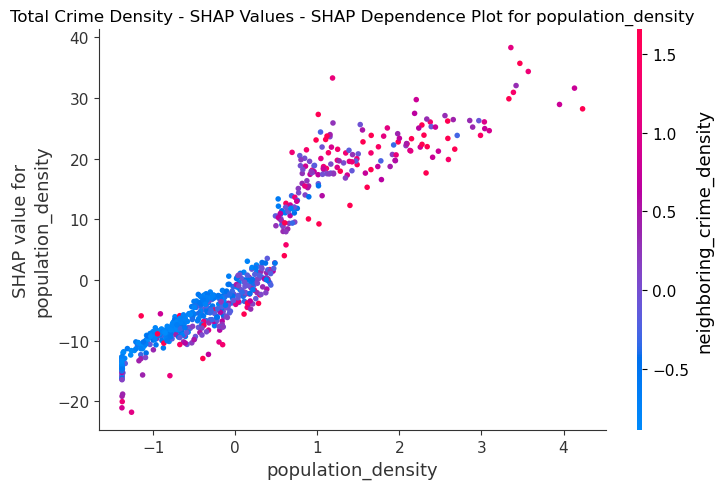

<Figure size 1200x800 with 0 Axes>

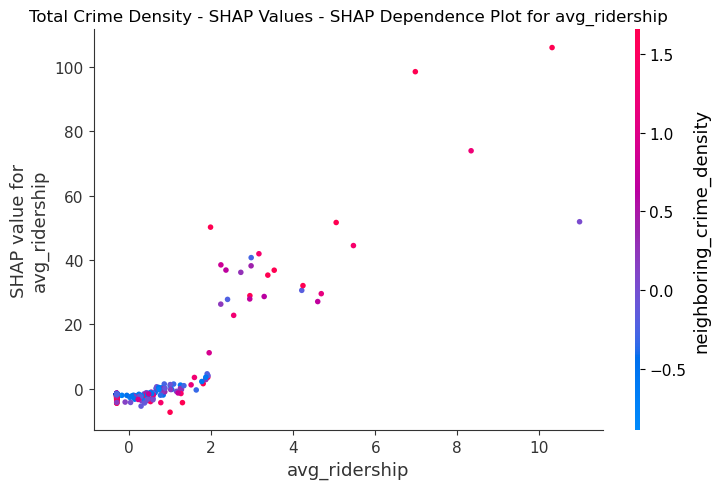

<Figure size 1200x800 with 0 Axes>

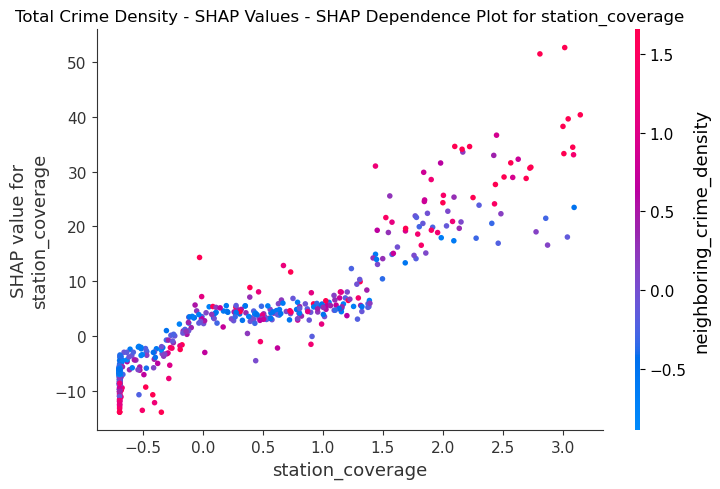

<Figure size 1200x800 with 0 Axes>

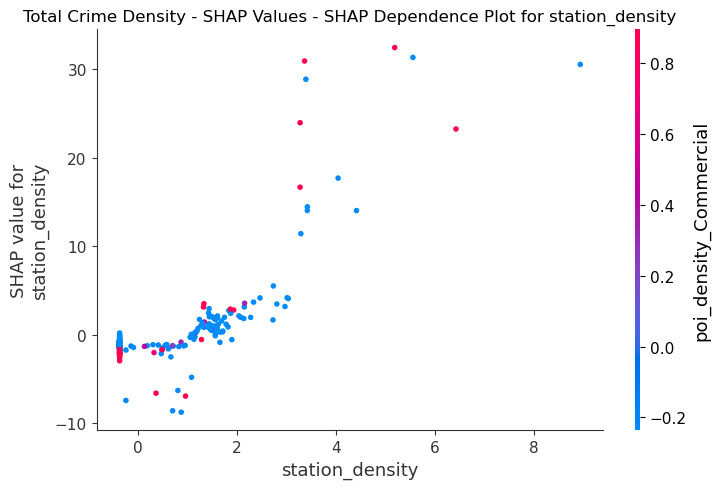

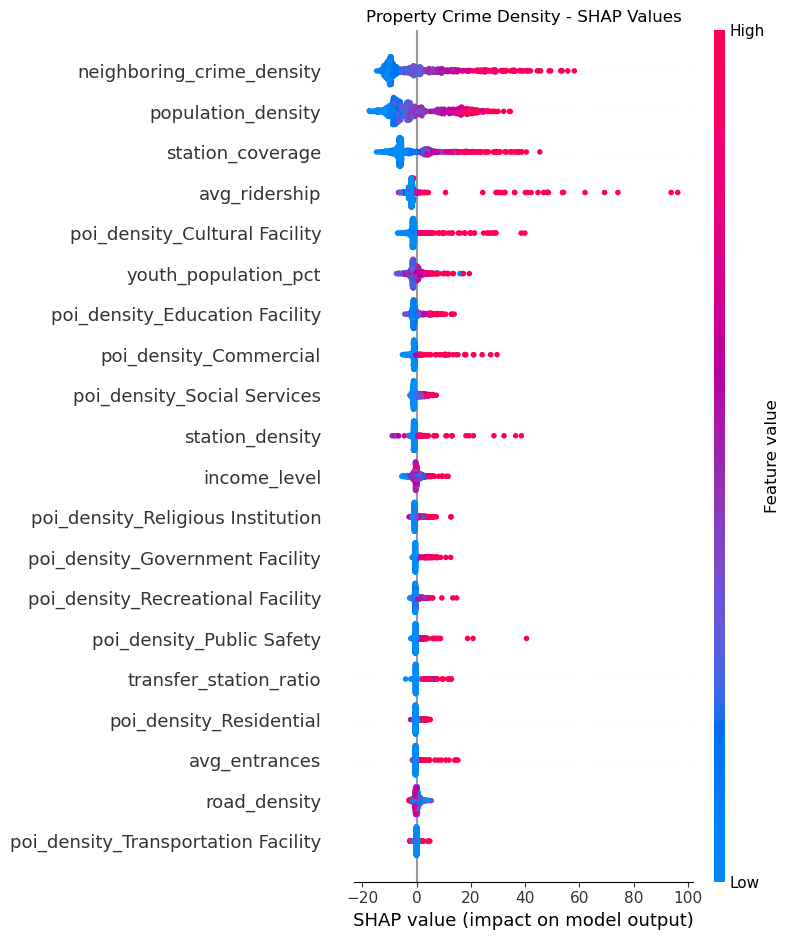

<Figure size 1200x800 with 0 Axes>

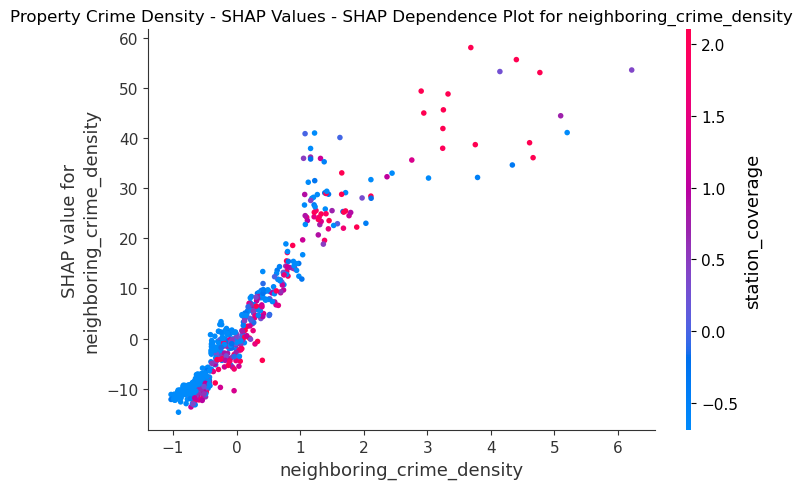

<Figure size 1200x800 with 0 Axes>

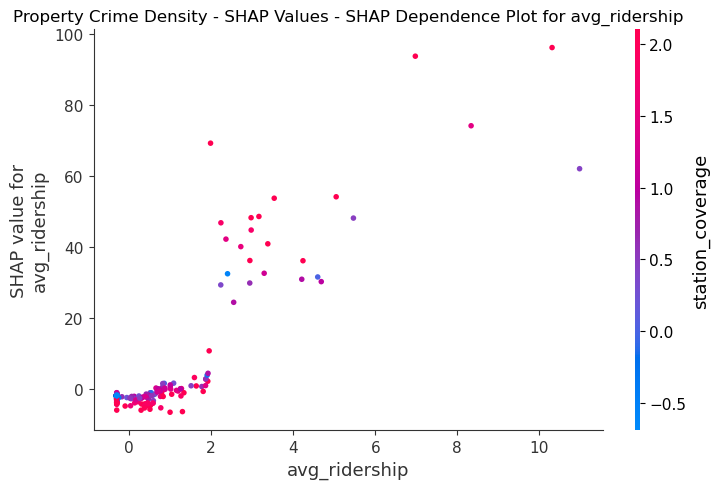

<Figure size 1200x800 with 0 Axes>

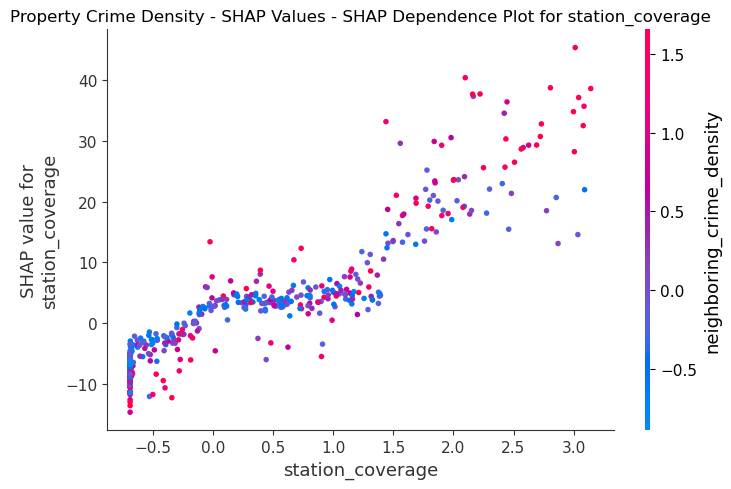

<Figure size 1200x800 with 0 Axes>

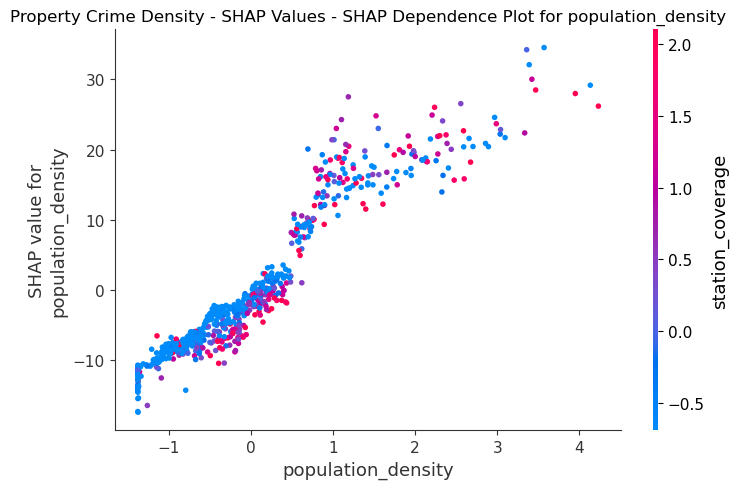

<Figure size 1200x800 with 0 Axes>

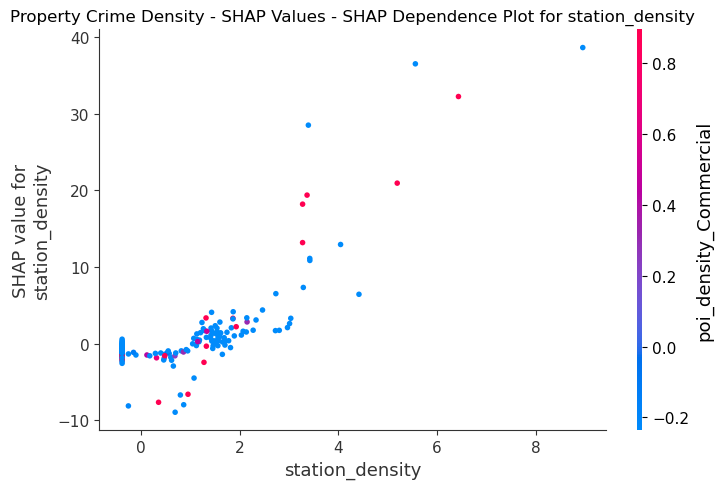

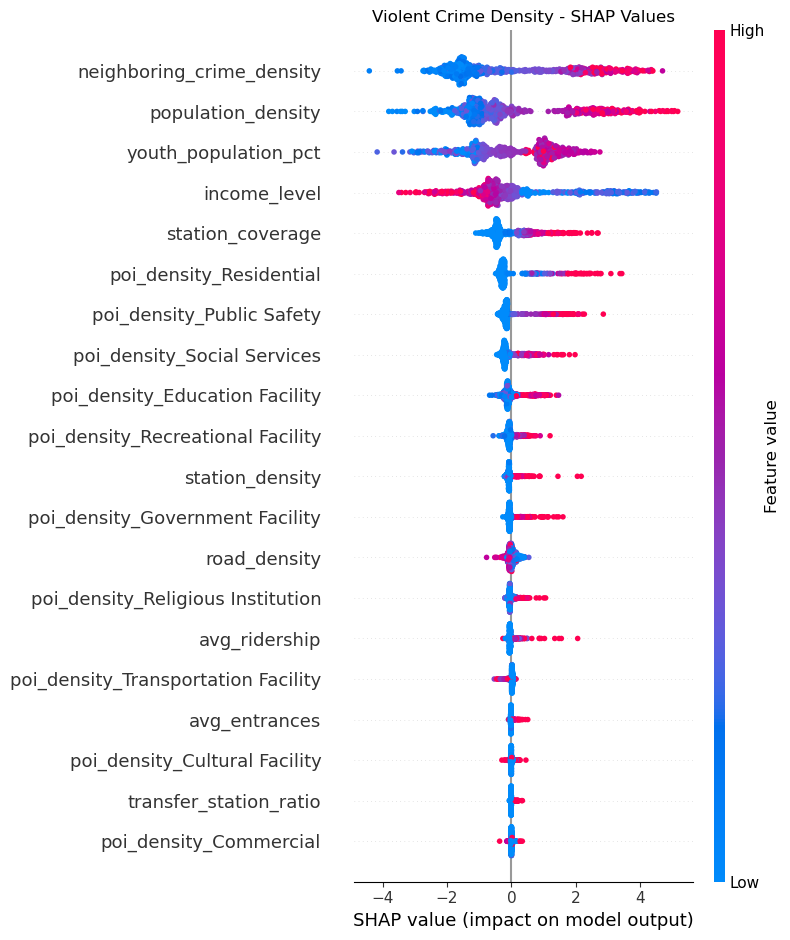

<Figure size 1200x800 with 0 Axes>

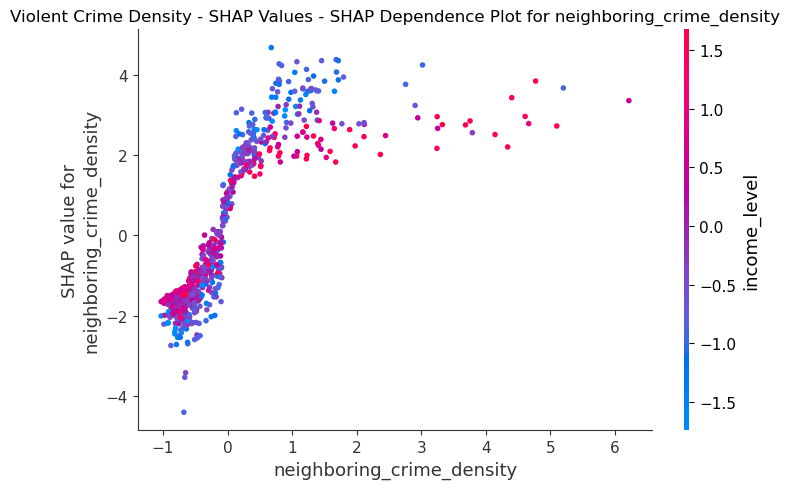

<Figure size 1200x800 with 0 Axes>

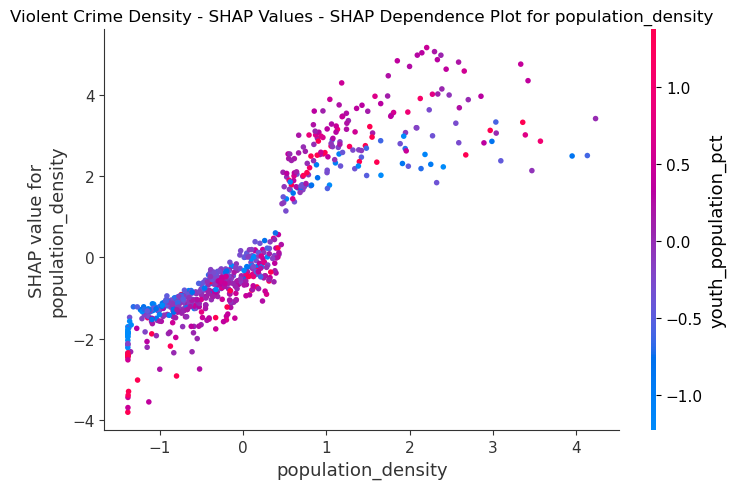

<Figure size 1200x800 with 0 Axes>

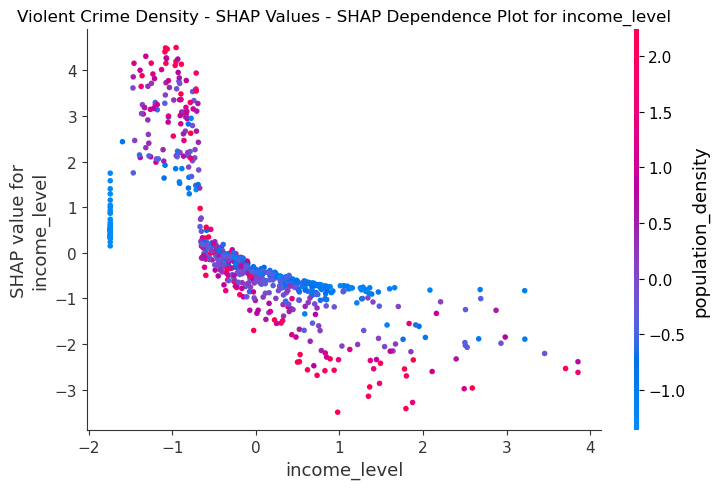

<Figure size 1200x800 with 0 Axes>

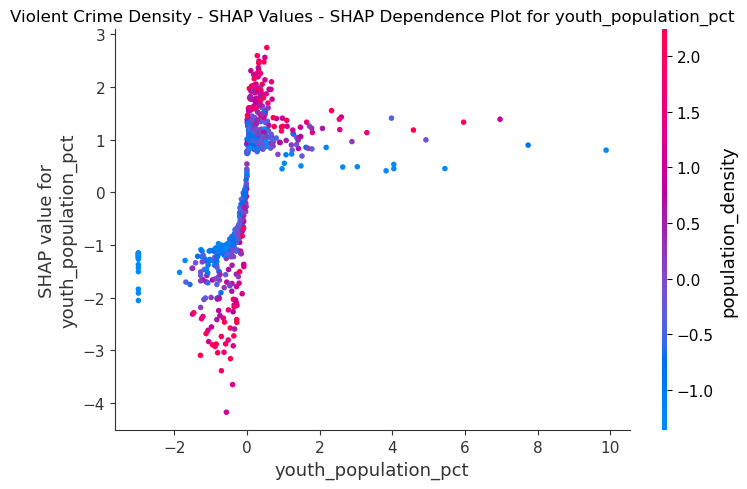

<Figure size 1200x800 with 0 Axes>

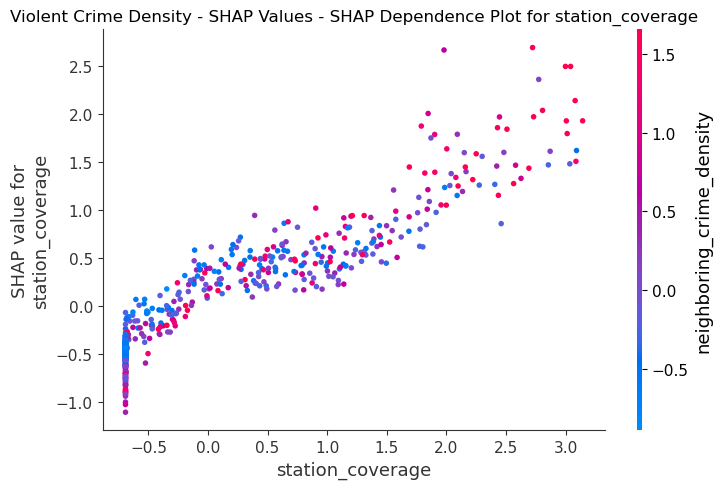

In [9]:
# 6. SHAP value analysis for deeper feature impact understanding
def analyze_shap_values(model, X_test, feature_names, title):
    """Analyze feature impact using SHAP values"""
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(12, 12))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(title)
    plt.tight_layout()
    
    # Save image and show
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_shap_summary.png"), dpi=300)
    plt.show()
    
    # Dependence plots for top 5 features
    top_indices = np.argsort(model.feature_importances_)[::-1][:5]
    top_features = [feature_names[i] for i in top_indices]
    
    for feature in top_features:
        plt.figure(figsize=(12, 8))
        shap.dependence_plot(feature, shap_values, X_test, feature_names=feature_names, show=False)
        plt.title(f"{title} - SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        
        # Save image and show
        plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_{feature.replace(' ', '_')}_dependence.png"), dpi=300)
        plt.show()

# Analyze SHAP values for each model
analyze_shap_values(total_model, X_test, features, "Total Crime Density - SHAP Values")
analyze_shap_values(property_model, X_test, features, "Property Crime Density - SHAP Values")
analyze_shap_values(violent_model, X_test, features, "Violent Crime Density - SHAP Values")

### Predict VS Actual

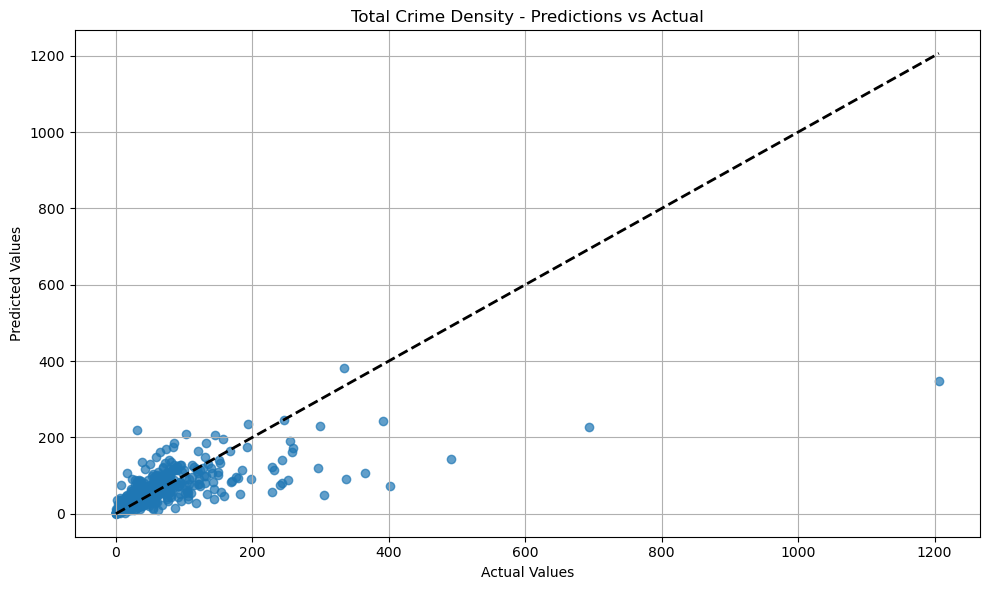

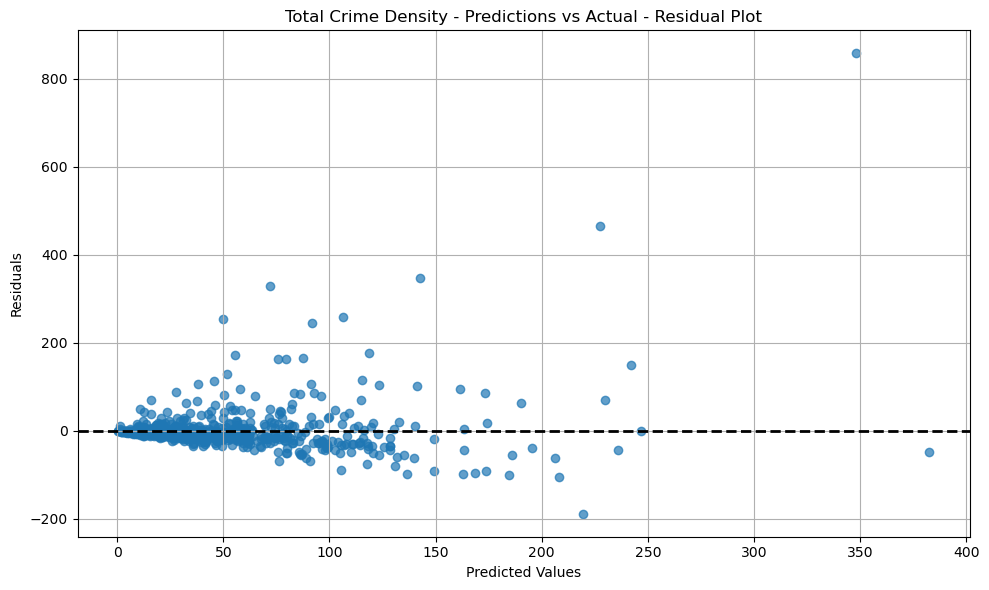

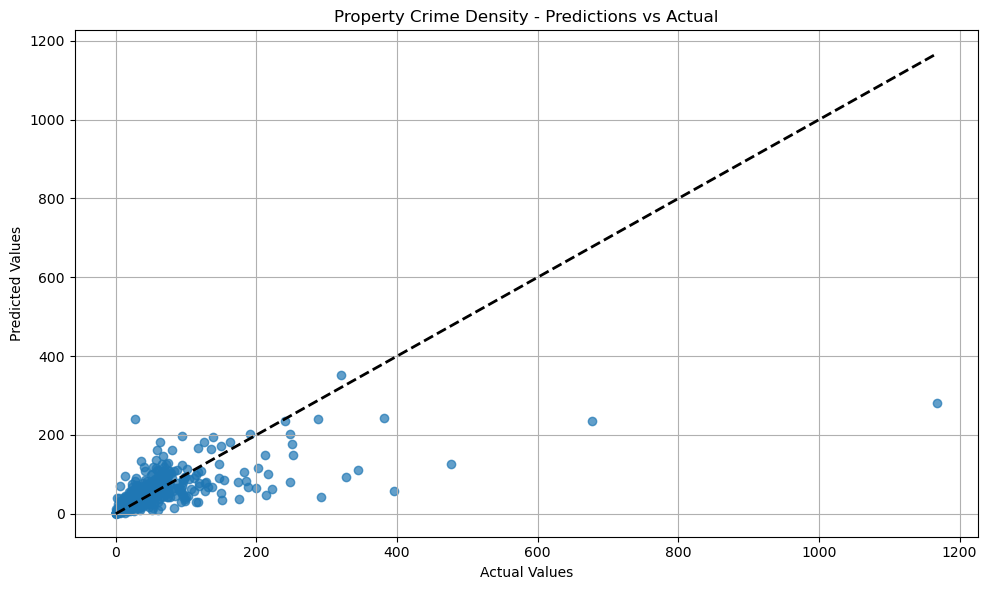

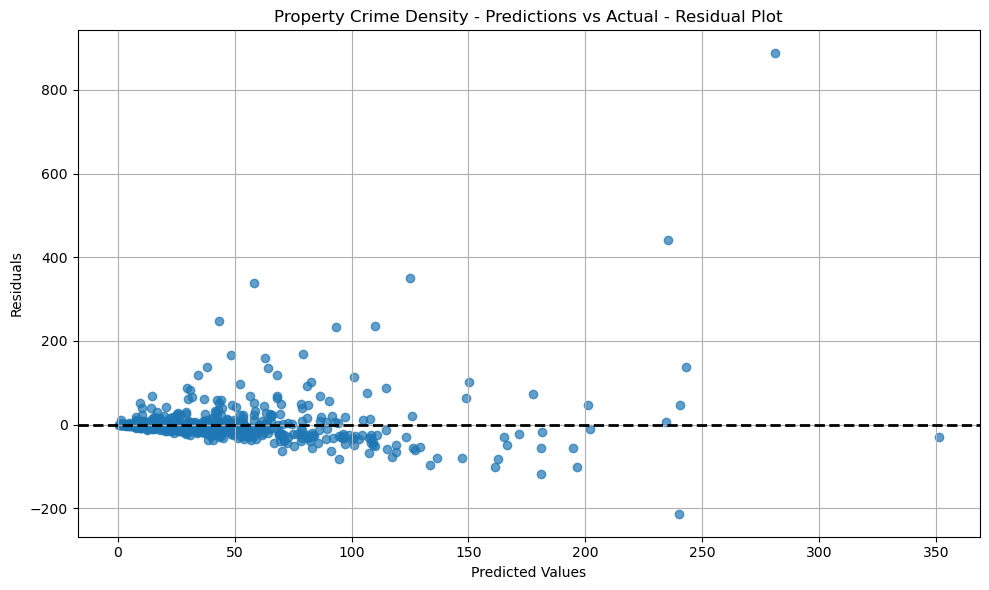

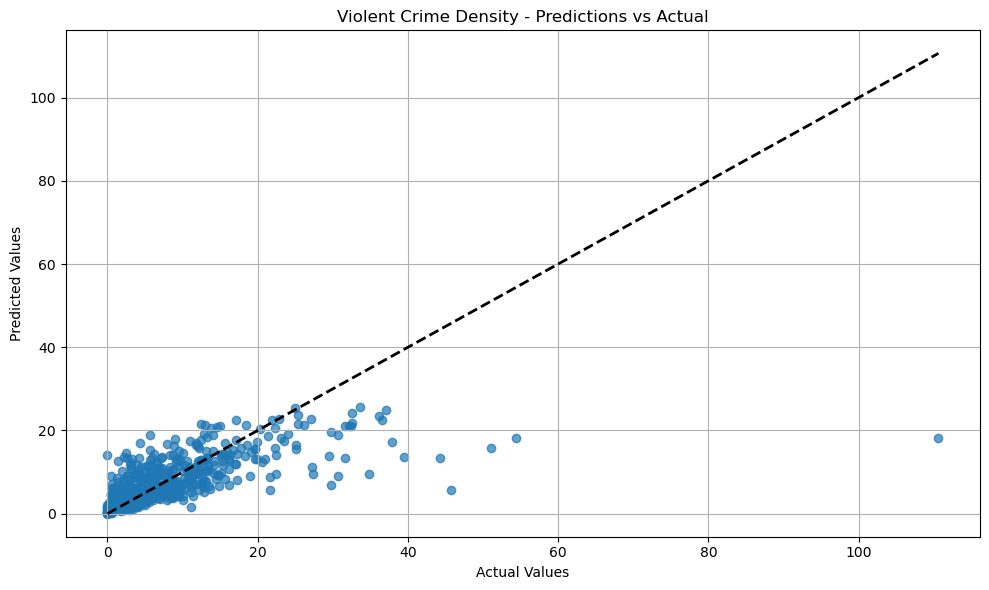

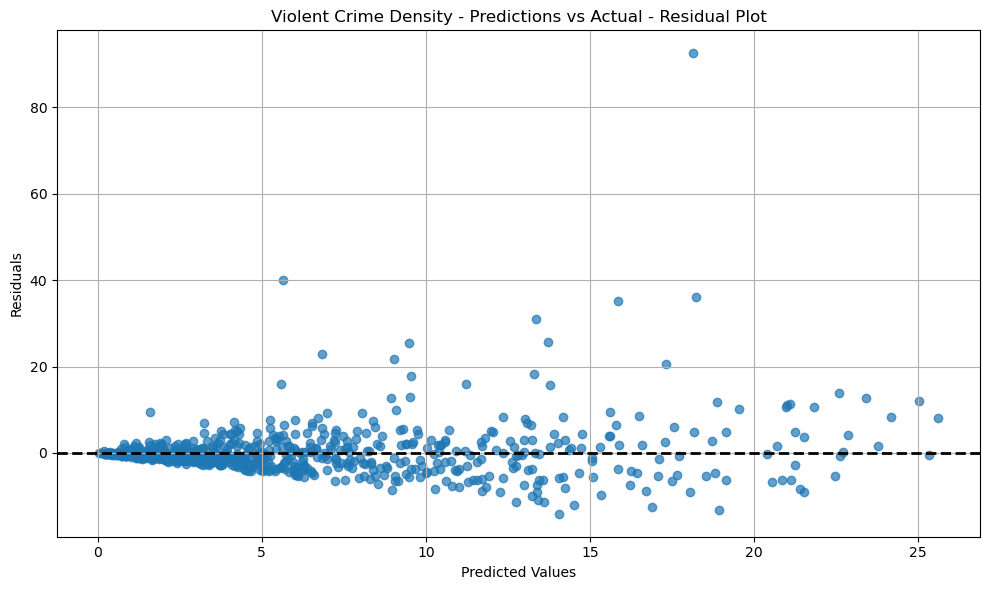

In [10]:
# 7. Analyze predictions vs actual values
def plot_predictions_vs_actual(y_test, y_pred, title):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    
    # Save image and show
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_predictions.png"), dpi=300)
    plt.show()
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f"{title} - Residual Plot")
    plt.grid(True)
    plt.tight_layout()
    
    # Save image and show
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_residuals.png"), dpi=300)
    plt.show()

# Plot prediction comparison
plot_predictions_vs_actual(y_total_test, total_pred, "Total Crime Density - Predictions vs Actual")
plot_predictions_vs_actual(y_property_test, property_pred, "Property Crime Density - Predictions vs Actual")
plot_predictions_vs_actual(y_violent_test, violent_pred, "Violent Crime Density - Predictions vs Actual")

### Group Performance Analysis


Total Crime Density - Performance by station_coverage Groups:
                     Group  Count          MSE       RMSE        R²  \
0     Low station_coverage    356   374.519272  19.352500  0.565048   
1  Medium station_coverage    105  1439.953849  37.946724  0.168456   
2    High station_coverage    237  7629.958285  87.349632  0.400586   

   Mean Abs Error  
0       10.263638  
1       21.439078  
2       41.260458  


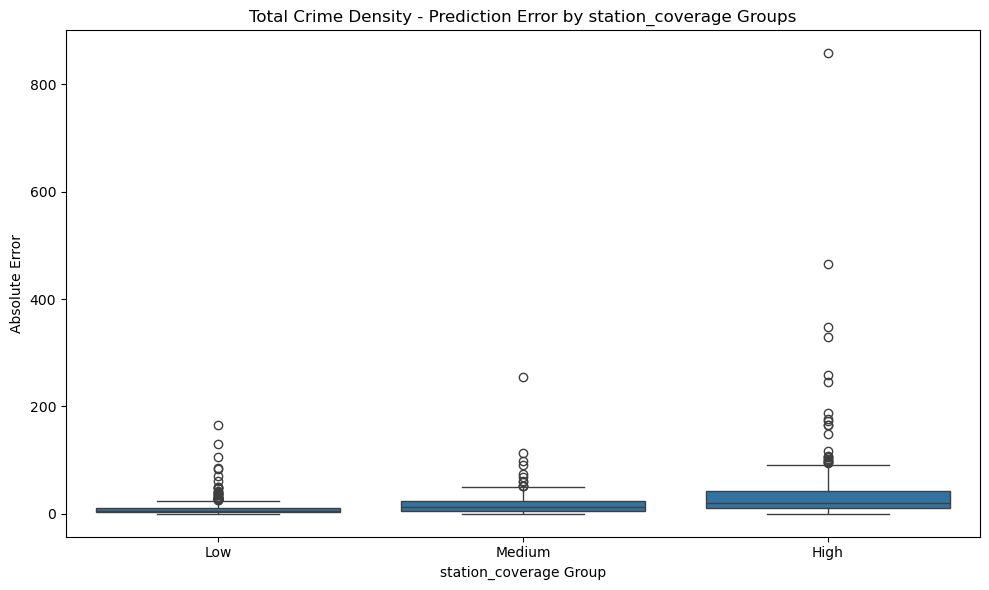


Total Crime Density - Performance by income_level Groups:
                 Group  Count          MSE       RMSE        R²  \
0     Low income_level    231  1984.728234  44.550289  0.378118   
1  Medium income_level    230  1199.810235  34.638277  0.319068   
2    High income_level    237  5731.626802  75.707508  0.527314   

   Mean Abs Error  
0       24.060432  
1       16.181529  
2       27.020992  


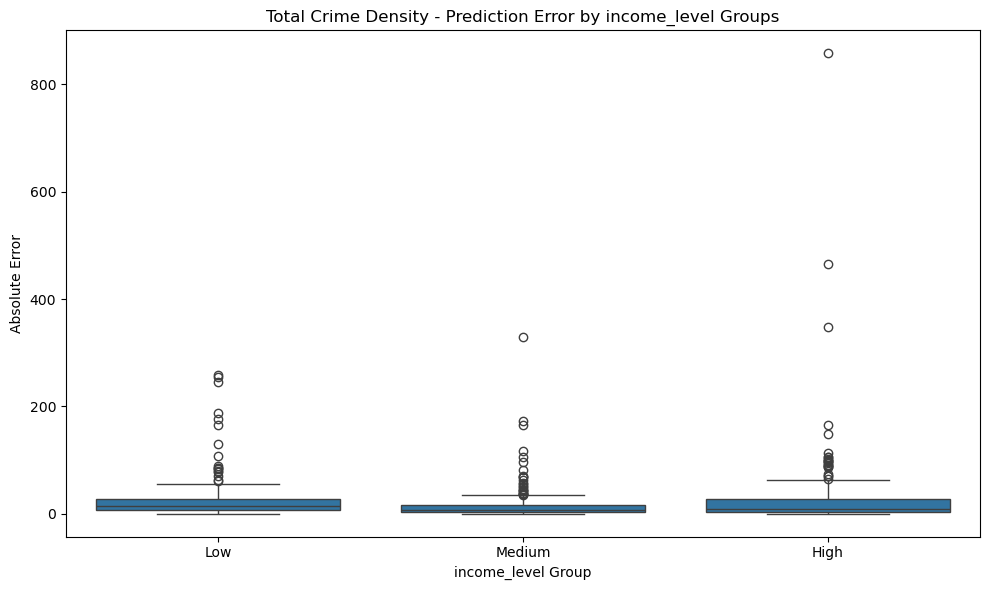


Property Crime Density - Performance by station_coverage Groups:
                     Group  Count          MSE       RMSE        R²  \
0     Low station_coverage    356   322.103100  17.947231  0.487689   
1  Medium station_coverage    105  1346.003400  36.687919  0.118112   
2    High station_coverage    237  7460.066161  86.371675  0.368290   

   Mean Abs Error  
0        9.106035  
1       19.993564  
2       39.198639  


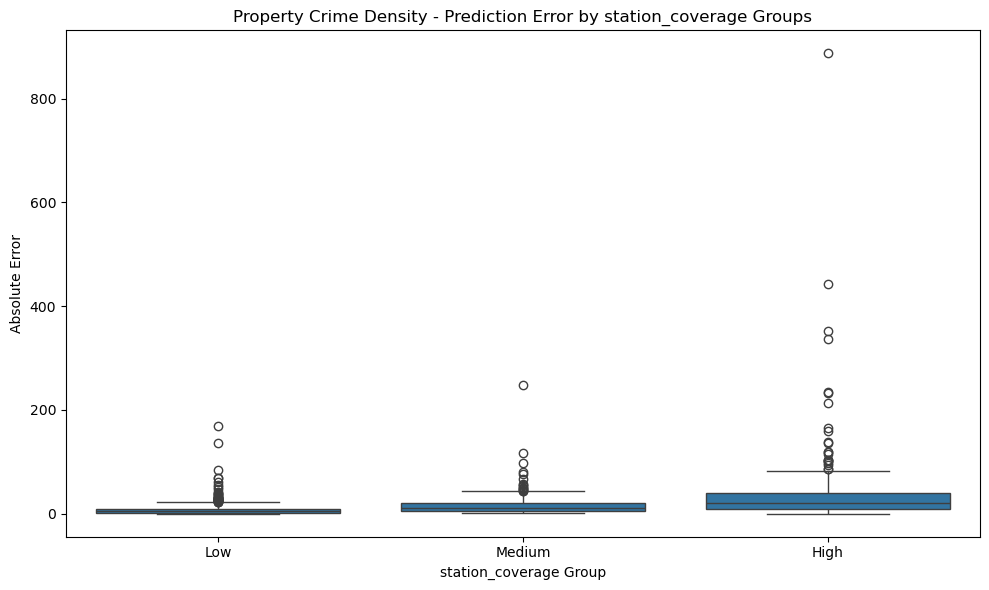


Property Crime Density - Performance by income_level Groups:
                 Group  Count          MSE       RMSE        R²  \
0     Low income_level    231  1747.162351  41.799071  0.268915   
1  Medium income_level    230  1116.871704  33.419631  0.254089   
2    High income_level    237  5753.416649  75.851280  0.494683   

   Mean Abs Error  
0       21.973020  
1       15.161891  
2       25.603998  


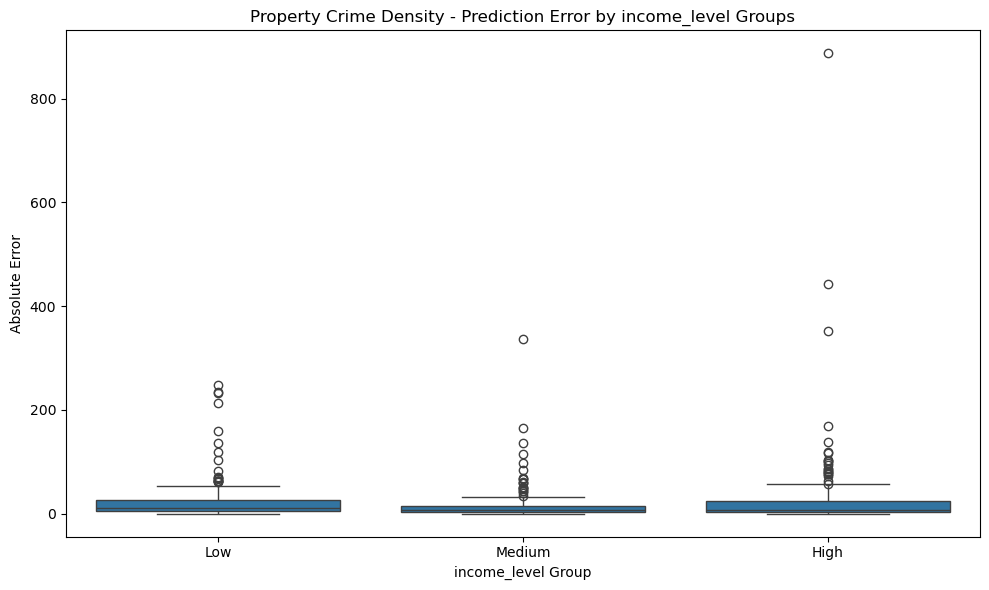


Violent Crime Density - Performance by station_coverage Groups:
                     Group  Count        MSE      RMSE        R²  \
0     Low station_coverage    356  15.136113  3.890516  0.612600   
1  Medium station_coverage    105  28.762279  5.363048  0.275643   
2    High station_coverage    237  80.208629  8.955927  0.383132   

   Mean Abs Error  
0        2.025447  
1        3.243419  
2        4.850324  


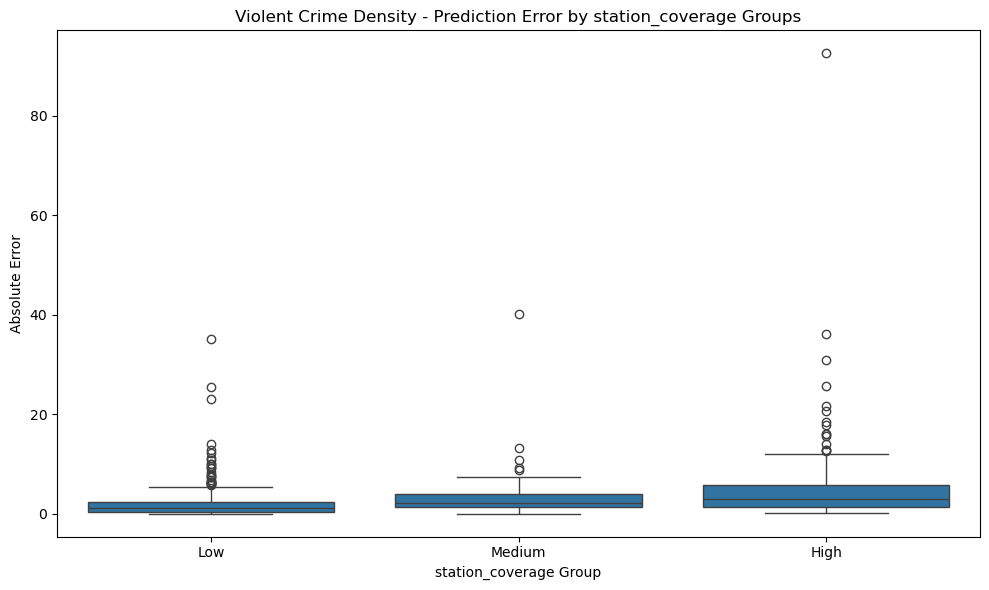


Violent Crime Density - Performance by income_level Groups:
                 Group  Count        MSE      RMSE        R²  Mean Abs Error
0     Low income_level    231  79.651963  8.924795  0.452410        4.496645
1  Medium income_level    230  22.745224  4.769195  0.373670        2.586773
2    High income_level    237  15.978632  3.997328  0.337844        2.436549


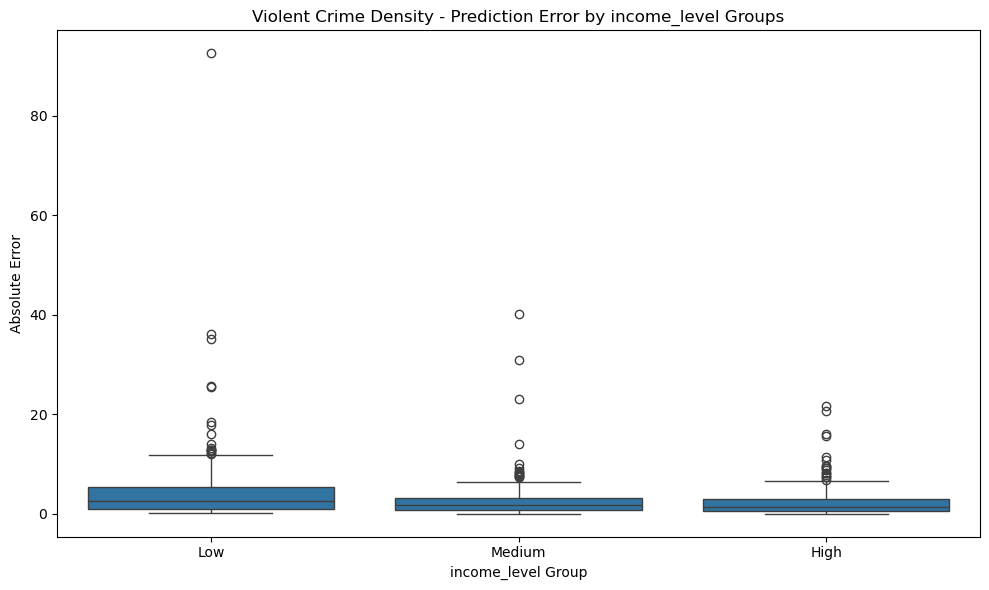

In [11]:
# 8. Group Performance Analysis - Evaluate model performance by subway coverage level
def group_performance_analysis(model, X_test, y_test, grouping_feature, name):
    """Analyze model performance across different groups based on a specific feature"""
    
    # Add predictions and errors to a copy of the test set
    X_test_with_target = X_test.copy()
    X_test_with_target['actual'] = y_test.values
    X_test_with_target['predicted'] = model.predict(X_test)
    X_test_with_target['error'] = abs(X_test_with_target['actual'] - X_test_with_target['predicted'])
    
    # Use raw (non-standardized) values for the grouping feature
    feature_values = df.loc[y_test.index, grouping_feature].values
    X_test_with_target['group_feature'] = feature_values
    
    # Define quantiles for grouping
    q33 = np.percentile(feature_values, 33)
    q66 = np.percentile(feature_values, 66)
    
    # Assign group labels
    X_test_with_target['group'] = pd.cut(
        X_test_with_target['group_feature'], 
        bins=[float('-inf'), q33, q66, float('inf')],
        labels=['Low', 'Medium', 'High']
    )
    
    # Compute performance metrics for each group
    group_results = []
    for group in ['Low', 'Medium', 'High']:
        group_data = X_test_with_target[X_test_with_target['group'] == group]
        if len(group_data) > 0:
            mse = mean_squared_error(group_data['actual'], group_data['predicted'])
            r2 = r2_score(group_data['actual'], group_data['predicted'])
            mean_error = group_data['error'].mean()
            
            group_results.append({
                'Group': f"{group} {grouping_feature}",
                'Count': len(group_data),
                'MSE': mse,
                'RMSE': np.sqrt(mse),
                'R²': r2,
                'Mean Abs Error': mean_error
            })
    
    # Create a DataFrame with the results
    group_df = pd.DataFrame(group_results)
    print(f"\n{name} - Performance by {grouping_feature} Groups:")
    print(group_df)
    
    # Save the results to a CSV file
    group_df.to_csv(os.path.join(OUTPUT_DIR, f"{name}_{grouping_feature}_group_performance.csv"), index=False)
    
    # Visualization: boxplot of prediction errors
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='group', y='error', data=X_test_with_target)
    plt.title(f"{name} - Prediction Error by {grouping_feature} Groups")
    plt.xlabel(f"{grouping_feature} Group")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}_{grouping_feature}_group_error.png"), dpi=300)
    plt.show()

# Run group performance analysis for each model
test_sets = [y_total_test, y_property_test, y_violent_test]
for name, model, y_test in zip(model_names, models, test_sets):
    # Group by subway coverage
    group_performance_analysis(model, X_test, y_test, 'station_coverage', name)
    # Group by income level
    group_performance_analysis(model, X_test, y_test, 'income_level', name)

### Model Comparison

In [12]:
# 9. Model comparison
results = []
for name, model, y_train, y_test, y_pred in zip(model_names, models, 
                                              [y_total_train, y_property_train, y_violent_train],
                                              [y_total_test, y_property_test, y_violent_test],
                                              [total_pred, property_pred, violent_pred]):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation R² - using training data for cross-validation
    cv_r2 = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='r2'))
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'Cross-validation R²': cv_r2
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Save model comparison results
results_df.to_csv(os.path.join(OUTPUT_DIR, "model_comparison.csv"), index=False)
with open(os.path.join(OUTPUT_DIR, "model_comparison.txt"), 'w') as f:
    f.write(results_df.to_string())


Model Comparison:
                    Model          MSE       RMSE        R²  \
0     Total Crime Density  2998.315370  54.756875  0.485754   
1  Property Crime Density  2899.763239  53.849450  0.443632   
2   Violent Crime Density    39.280717   6.267433  0.499600   

   Cross-validation R²  
0             0.498621  
1             0.461390  
2             0.607852  


### Permutation Importance Analysis

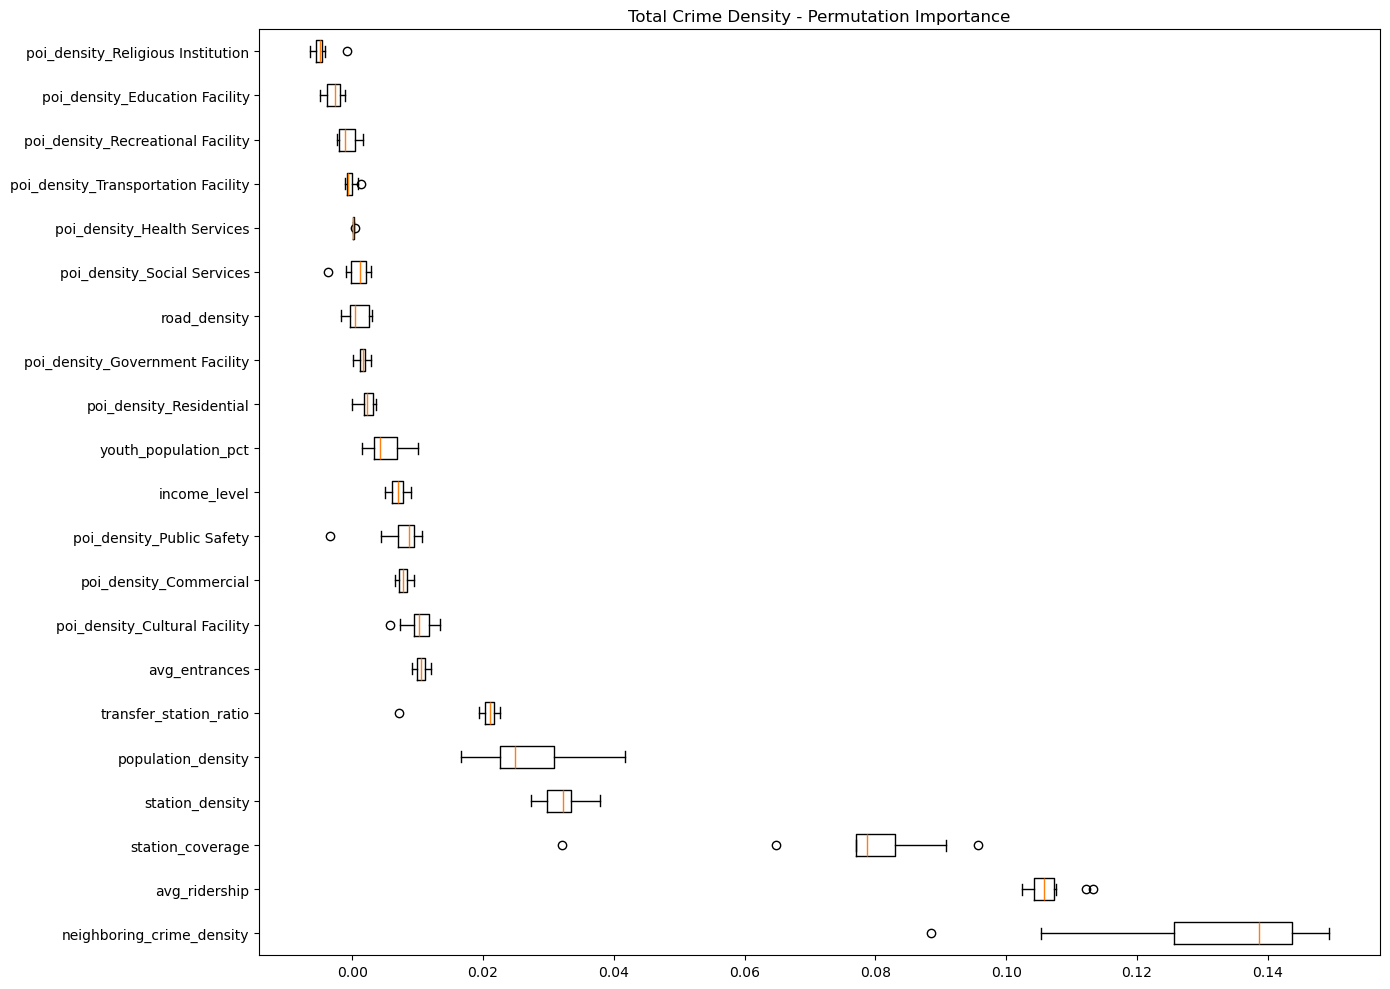


Total Crime Density - Permutation Importance - Permutation Importance Ranking:
neighboring_crime_density: 0.1308 ± 0.0187
avg_ridership: 0.1066 ± 0.0034
station_coverage: 0.0759 ± 0.0166
station_density: 0.0320 ± 0.0030
population_density: 0.0266 ± 0.0072
transfer_station_ratio: 0.0197 ± 0.0043
avg_entrances: 0.0105 ± 0.0008
poi_density_Cultural Facility: 0.0101 ± 0.0022
poi_density_Commercial: 0.0078 ± 0.0009
poi_density_Public Safety: 0.0072 ± 0.0039
income_level: 0.0070 ± 0.0013
youth_population_pct: 0.0053 ± 0.0027
poi_density_Residential: 0.0022 ± 0.0012
poi_density_Government Facility: 0.0016 ± 0.0007
road_density: 0.0009 ± 0.0016
poi_density_Social Services: 0.0007 ± 0.0019
poi_density_Health Services: 0.0002 ± 0.0001
poi_density_Transportation Facility: -0.0003 ± 0.0008
poi_density_Recreational Facility: -0.0007 ± 0.0014
poi_density_Education Facility: -0.0028 ± 0.0012
poi_density_Religious Institution: -0.0047 ± 0.0015


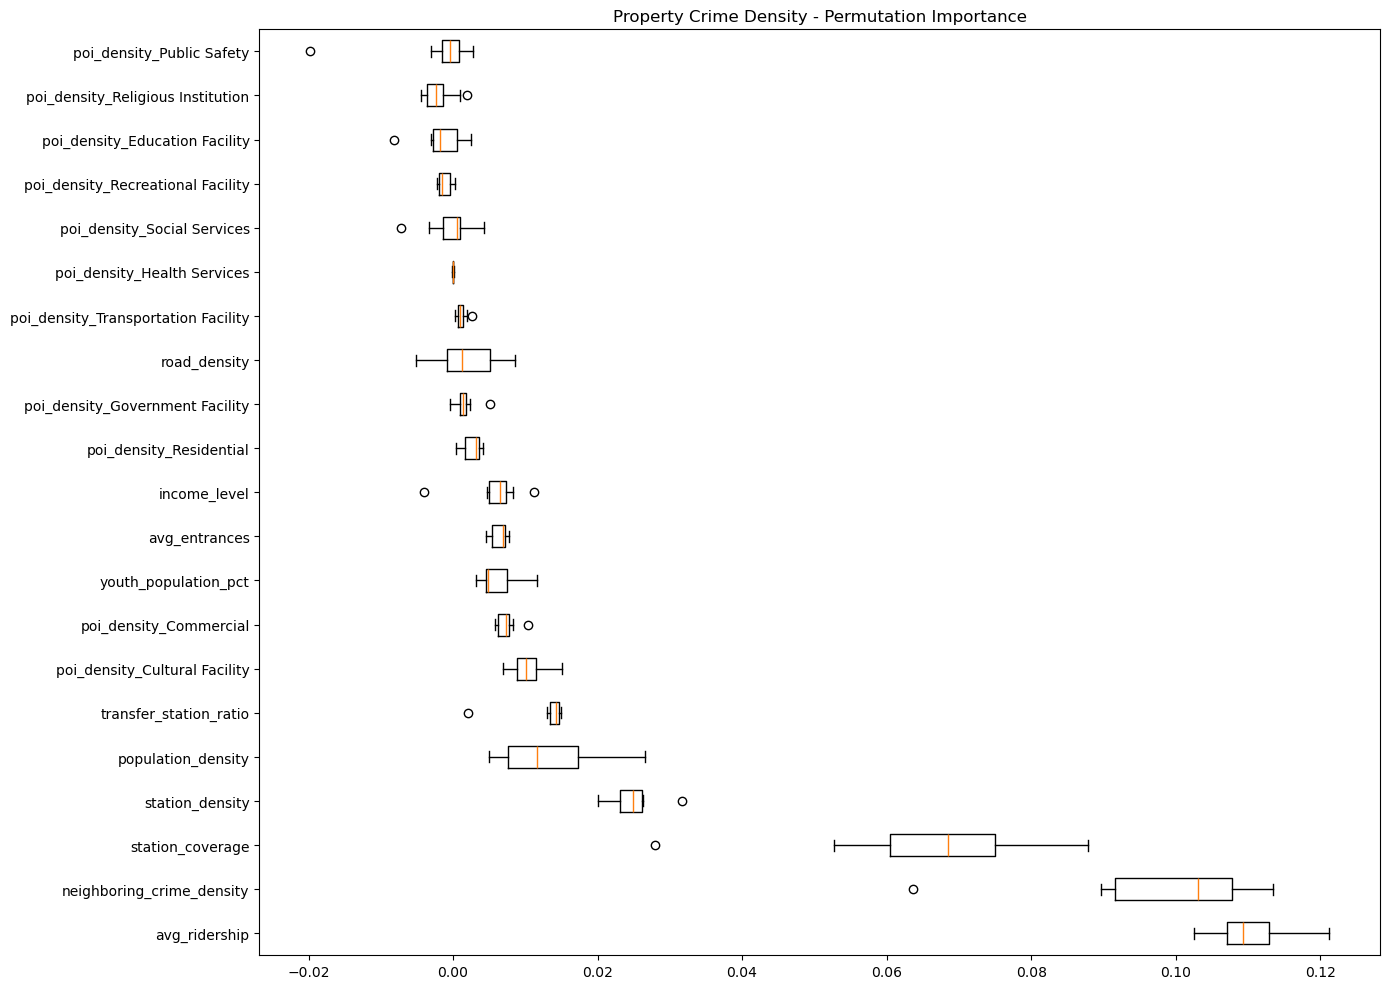


Property Crime Density - Permutation Importance - Permutation Importance Ranking:
avg_ridership: 0.1102 ± 0.0050
neighboring_crime_density: 0.0982 ± 0.0138
station_coverage: 0.0655 ± 0.0156
station_density: 0.0249 ± 0.0030
population_density: 0.0132 ± 0.0068
transfer_station_ratio: 0.0129 ± 0.0037
poi_density_Cultural Facility: 0.0104 ± 0.0022
poi_density_Commercial: 0.0073 ± 0.0013
youth_population_pct: 0.0064 ± 0.0028
avg_entrances: 0.0064 ± 0.0011
income_level: 0.0058 ± 0.0037
poi_density_Residential: 0.0027 ± 0.0012
poi_density_Government Facility: 0.0016 ± 0.0014
road_density: 0.0016 ± 0.0043
poi_density_Transportation Facility: 0.0011 ± 0.0007
poi_density_Health Services: 0.0000 ± 0.0001
poi_density_Social Services: -0.0004 ± 0.0030
poi_density_Recreational Facility: -0.0012 ± 0.0008
poi_density_Education Facility: -0.0016 ± 0.0029
poi_density_Religious Institution: -0.0020 ± 0.0020
poi_density_Public Safety: -0.0021 ± 0.0061


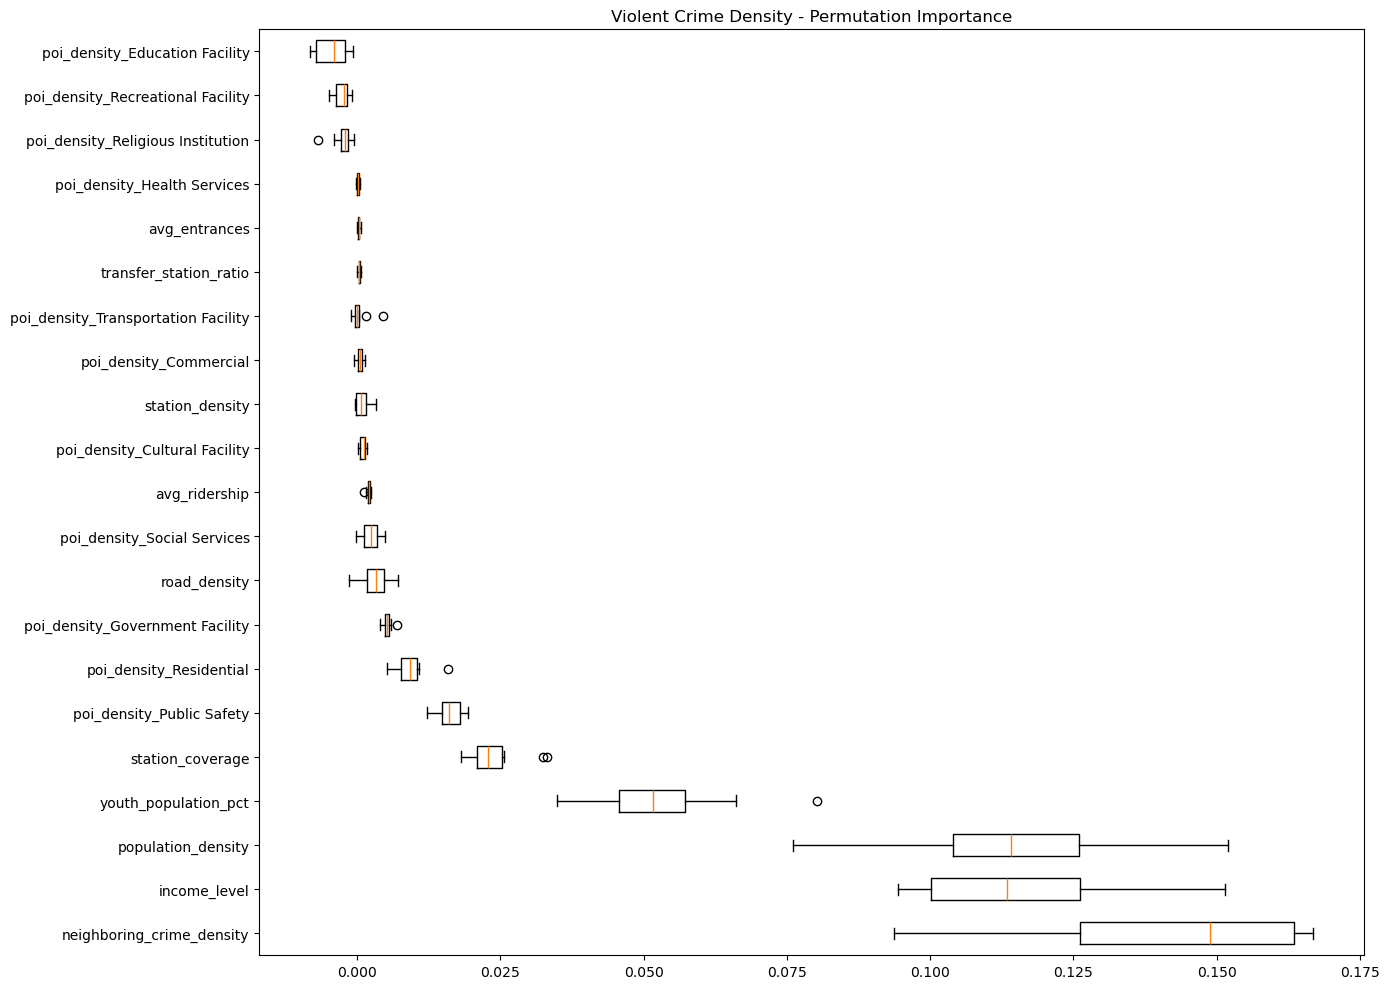


Violent Crime Density - Permutation Importance - Permutation Importance Ranking:
neighboring_crime_density: 0.1427 ± 0.0233
income_level: 0.1170 ± 0.0188
population_density: 0.1147 ± 0.0212
youth_population_pct: 0.0536 ± 0.0120
station_coverage: 0.0240 ± 0.0050
poi_density_Public Safety: 0.0161 ± 0.0021
poi_density_Residential: 0.0093 ± 0.0028
poi_density_Government Facility: 0.0053 ± 0.0008
road_density: 0.0032 ± 0.0024
poi_density_Social Services: 0.0022 ± 0.0016
avg_ridership: 0.0020 ± 0.0004
poi_density_Cultural Facility: 0.0010 ± 0.0005
station_density: 0.0008 ± 0.0011
poi_density_Commercial: 0.0005 ± 0.0005
poi_density_Transportation Facility: 0.0004 ± 0.0015
transfer_station_ratio: 0.0004 ± 0.0002
avg_entrances: 0.0002 ± 0.0002
poi_density_Health Services: 0.0002 ± 0.0002
poi_density_Religious Institution: -0.0026 ± 0.0017
poi_density_Recreational Facility: -0.0027 ± 0.0013
poi_density_Education Facility: -0.0044 ± 0.0028


In [13]:
# 10. Permutation importance analysis (more robust feature importance measure)
def plot_permutation_importance(model, X, y, feature_names, title):
    """Calculate and plot permutation importance"""
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    # Sort indices
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    
    plt.figure(figsize=(14, 10))
    plt.title(title)
    plt.boxplot(perm_importance.importances[sorted_idx].T, 
                vert=False, labels=[feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    
    # Save image and show
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}.png"), dpi=300)
    plt.show()
    
    # Print sorted permutation importance
    print(f"\n{title} - Permutation Importance Ranking:")
    
    # Save permutation importance to text file
    with open(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}.txt"), 'w') as f:
        for i in sorted_idx:
            importance_str = f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}"
            print(importance_str)
            f.write(importance_str + "\n")

# Calculate permutation importance for each model
plot_permutation_importance(total_model, X_test, y_total_test, features, "Total Crime Density - Permutation Importance")
plot_permutation_importance(property_model, X_test, y_property_test, features, "Property Crime Density - Permutation Importance")
plot_permutation_importance(violent_model, X_test, y_violent_test, features, "Violent Crime Density - Permutation Importance")

In [14]:
# 11. Save models
# Save models to specified directory
joblib.dump(total_model, os.path.join(OUTPUT_DIR, 'total_crime_rf_model.pkl'))
joblib.dump(property_model, os.path.join(OUTPUT_DIR, 'property_crime_rf_model.pkl'))
joblib.dump(violent_model, os.path.join(OUTPUT_DIR, 'violent_crime_rf_model.pkl'))
# Save scaler
joblib.dump(scaler, os.path.join(OUTPUT_DIR, 'feature_scaler.pkl'))

print(f"\nModels and results saved to {OUTPUT_DIR} directory")


Models and results saved to output/modeling directory


## Gaussian Process model

In [15]:
import geopandas as gpd
df = pd.read_csv('processed_data/ct_integrated_data.csv')
df = df.drop(columns=['Pop15t19', 'Pop20t24', 'Pop25t29'])
from shapely import wkt

In [16]:
# Function for extracting centroids from geometry column
def extract_centroids_from_geometry(df):
    """Extract centroid coordinates from the geometry column of a DataFrame"""
    if 'geometry' not in df.columns:
        print("Geometry column not found in DataFrame")
        return df
    
    try:
        # Try to import necessary libraries
        import shapely.wkt
        
        # Create new columns to store centroid coordinates
        centroids = []
        
        # Iterate through geometry column
        for geom_str in df['geometry']:
            try:
                # Try to convert WKT string to shapely geometry object
                geom = shapely.wkt.loads(geom_str)
                # Get centroid
                centroid = geom.centroid
                centroids.append((centroid.x, centroid.y))
            except Exception as e:
                print(f"Error processing geometry object: {e}")
                centroids.append((np.nan, np.nan))
        
        # Add centroid coordinates to DataFrame
        df['centroid_x'] = [c[0] for c in centroids]
        df['centroid_y'] = [c[1] for c in centroids]
        
        # Check for NaN values
        nan_count = df['centroid_x'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in extracted centroids")
            # Fill NaN values with means
            mean_x = df['centroid_x'].mean()
            mean_y = df['centroid_y'].mean()
            df['centroid_x'] = df['centroid_x'].fillna(mean_x)
            df['centroid_y'] = df['centroid_y'].fillna(mean_y)
        
        return df
    
    except ImportError:
        print("Could not import shapely library. Trying alternative methods to extract coordinates...")
        
        # Alternative method: try to parse geometric data in string form
        try:
            # Assume geometry is in string form containing coordinates
            centroids = []
            for geom_str in df['geometry']:
                try:
                    # Try to extract coordinates through string processing
                    # This is a simplified example, may need adjustment based on actual format
                    if "POINT" in geom_str:
                        # Extract coordinates from POINT
                        coords = geom_str.replace("POINT(", "").replace(")", "").split()
                        centroids.append((float(coords[0]), float(coords[1])))
                    elif "POLYGON" in geom_str or "MULTIPOLYGON" in geom_str:
                        # Extract first coordinate as approximate centroid
                        # This is not a true centroid, but can serve as an approximation for visualization
                        coords_part = geom_str.split("((")[1].split(",")[0].split()
                        centroids.append((float(coords_part[0]), float(coords_part[1])))
                    else:
                        # Unrecognized format
                        centroids.append((np.nan, np.nan))
                except Exception:
                    centroids.append((np.nan, np.nan))
            
            # Add centroid coordinates to DataFrame
            df['centroid_x'] = [c[0] for c in centroids]
            df['centroid_y'] = [c[1] for c in centroids]
            
            # Check for NaN values
            nan_count = df['centroid_x'].isna().sum()
            if nan_count > 0:
                print(f"Warning: {nan_count} NaN values in extracted centroids")
                # Create random coordinates
                np.random.seed(42)
                for i in df.index[df['centroid_x'].isna()]:
                    df.loc[i, 'centroid_x'] = np.random.uniform(0, 100)
                    df.loc[i, 'centroid_y'] = np.random.uniform(0, 100)
            
            return df
        
        except Exception as e:
            print(f"Error extracting coordinates: {e}")
            print("Using random coordinates as fallback")
            
            # Use random coordinates as a last resort fallback
            np.random.seed(42)
            df['centroid_x'] = np.random.uniform(0, 100, size=len(df))
            df['centroid_y'] = np.random.uniform(0, 100, size=len(df))
            return df

In [17]:
# Feature preprocessing function for Gaussian Process models
def preprocess_features_for_gp(X_train, X_test, y_train, max_features=10):
    """Preprocess features for Gaussian Process model, including feature selection and standardization"""
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.preprocessing import StandardScaler
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection
    selector = SelectKBest(f_regression, k=max_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Get selected feature indices and names
    selected_indices = selector.get_support(indices=True)
    
    return X_train_selected, X_test_selected, selected_indices

In [18]:
# Gaussian Process (GP) Model Analysis for Spatial Correlation
print("\nStarting Gaussian Process model analysis (using all features)...")

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist
import scipy.stats as stats

# Create directory for Gaussian Process model results
GP_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "gaussian_process")
os.makedirs(GP_OUTPUT_DIR, exist_ok=True)

# Extract centroid coordinates from geometry data
print("Extracting centroid coordinates from geometry data...")
df = extract_centroids_from_geometry(df)

# Using the same features as the random forest model
# Record all training and test data values
X_train_values = X_train.values
X_test_values = X_test.values
y_total_train_values = y_total_train.values
y_total_test_values = y_total_test.values
y_property_train_values = y_property_train.values
y_property_test_values = y_property_test.values
y_violent_train_values = y_violent_train.values
y_violent_test_values = y_violent_test.values

# Check for NaN values in training and test data
print(f"Number of NaN values in X_train: {np.isnan(X_train_values).sum()}")
print(f"Number of NaN values in X_test: {np.isnan(X_test_values).sum()}")

# Impute NaN values - Gaussian Process models require all inputs to be valid numbers
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_values)
X_test_imputed = imputer.transform(X_test_values)

# Verify no more NaN values
print(f"Number of NaN values in X_train after imputation: {np.isnan(X_train_imputed).sum()}")
print(f"Number of NaN values in X_test after imputation: {np.isnan(X_test_imputed).sum()}")

# Check for NaN values in target variables
for name, y_train, y_test in zip(
    ['Total Crime', 'Property Crime', 'Violent Crime'],
    [y_total_train_values, y_property_train_values, y_violent_train_values],
    [y_total_test_values, y_property_test_values, y_violent_test_values]
):
    print(f"Number of NaN values in {name} training set: {np.isnan(y_train).sum()}")
    print(f"Number of NaN values in {name} test set: {np.isnan(y_test).sum()}")

# Impute target variables with NaN values if needed
y_total_train_imputed = np.nan_to_num(y_total_train_values, nan=np.nanmean(y_total_train_values))
y_total_test_imputed = np.nan_to_num(y_total_test_values, nan=np.nanmean(y_total_test_values))
y_property_train_imputed = np.nan_to_num(y_property_train_values, nan=np.nanmean(y_property_train_values))
y_property_test_imputed = np.nan_to_num(y_property_test_values, nan=np.nanmean(y_property_test_values))
y_violent_train_imputed = np.nan_to_num(y_violent_train_values, nan=np.nanmean(y_violent_train_values))
y_violent_test_imputed = np.nan_to_num(y_violent_test_values, nan=np.nanmean(y_violent_test_values))

# Extract coordinates for visualization
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()

# Create spatial coordinate arrays for visualization only
X_train_coords = np.array([[df['centroid_x'].iloc[i], df['centroid_y'].iloc[i]] for i in train_indices])
X_test_coords = np.array([[df['centroid_x'].iloc[i], df['centroid_y'].iloc[i]] for i in test_indices])

print(f"Training set shape: {X_train_imputed.shape}, Test set shape: {X_test_imputed.shape}")


Starting Gaussian Process model analysis (using all features)...
Extracting centroid coordinates from geometry data...
Number of NaN values in X_train: 0
Number of NaN values in X_test: 0
Number of NaN values in X_train after imputation: 0
Number of NaN values in X_test after imputation: 0
Number of NaN values in Total Crime training set: 0
Number of NaN values in Total Crime test set: 0
Number of NaN values in Property Crime training set: 0
Number of NaN values in Property Crime test set: 0
Number of NaN values in Violent Crime training set: 0
Number of NaN values in Violent Crime test set: 0
Training set shape: (1627, 21), Test set shape: (698, 21)


In [19]:
def fit_gp_model_improved(X_train_imputed, y_train_imputed, title):
    """Improved Gaussian Process model training function"""
    # Define kernels with more reasonable initial parameters and bounds
    kernels = {
        'RBF': 1.0 * RBF(length_scale=[1.0] * X_train_imputed.shape[1], 
                         length_scale_bounds=(0.1, 100.0)) + WhiteKernel(noise_level=1.0, 
                                                                          noise_level_bounds=(0.1, 100.0)),
        'Matern': 1.0 * Matern(length_scale=[1.0] * X_train_imputed.shape[1], 
                                nu=1.5, 
                                length_scale_bounds=(0.1, 100.0)) + WhiteKernel(noise_level=1.0, 
                                                                                 noise_level_bounds=(0.1, 100.0)),
        'RationalQuadratic': 1.0 * RationalQuadratic(length_scale=1.0, 
                                                     alpha=0.1, 
                                                     length_scale_bounds=(0.1, 100.0),
                                                     alpha_bounds=(0.01, 10.0)) + WhiteKernel(noise_level=1.0, 
                                                                                              noise_level_bounds=(0.1, 100.0))
    }
    
    best_model = None
    best_score = -float('inf')
    best_kernel_name = None
    
    # Implement k-fold cross-validation instead of simple splitting
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for kernel_name, kernel in kernels.items():
        print(f"\nTrying {kernel_name} kernel...")
        
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_imputed):
            # Get training and validation sets for this fold
            X_fold_train, X_fold_val = X_train_imputed[train_idx], X_train_imputed[val_idx]
            y_fold_train, y_fold_val = y_train_imputed[train_idx], y_train_imputed[val_idx]
            
            # Initialize and train model
            gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=3,  # Reduce number of restarts to save time
                random_state=42,
                normalize_y=True  # Add target variable normalization
            )
            
            try:
                gp.fit(X_fold_train, y_fold_train)
                y_fold_pred = gp.predict(X_fold_val)
                fold_r2 = r2_score(y_fold_val, y_fold_pred)
                cv_scores.append(fold_r2)
            except Exception as e:
                print(f"  Fold {len(cv_scores)+1} error: {e}")
                cv_scores.append(-float('inf'))
        
        # Calculate average cross-validation score
        mean_cv_score = np.mean([s for s in cv_scores if s != -float('inf')])
        if len([s for s in cv_scores if s != -float('inf')]) == 0:
            mean_cv_score = -float('inf')
        
        print(f"{kernel_name} cross-validation R²: {mean_cv_score:.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_kernel_name = kernel_name
            
            # Retrain on all training data
            final_gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=5,
                random_state=42,
                normalize_y=True
            )
            try:
                final_gp.fit(X_train_imputed, y_train_imputed)
                best_model = final_gp
            except Exception as e:
                print(f"Final model training failed: {e}")
    
    if best_model is not None:
        print(f"\nBest kernel: {best_kernel_name}, cross-validation R²: {best_score:.4f}")
        print(f"Optimized kernel parameters: {best_model.kernel_}")
        
        # Check if optimized parameters are reasonable
        params_reasonable = True
        if best_kernel_name == "RationalQuadratic":
            # Extract main parameters
            try:
                length_scale = best_model.kernel_.k1.length_scale
                alpha = best_model.kernel_.k1.alpha
                noise_level = best_model.kernel_.k2.noise_level
                
                # Check if parameters are within reasonable ranges
                if length_scale > 1000 or noise_level > 1000:
                    params_reasonable = False
                    print(f"Warning: Optimized parameters are unreasonable (length_scale={length_scale}, noise_level={noise_level})")
                    print("Trying second best kernel...")
            except:
                print("Unable to parse kernel parameters")
        
        if not params_reasonable:
            # Use simpler Matern kernel as fallback
            backup_kernel = 1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)
            backup_model = GaussianProcessRegressor(
                kernel=backup_kernel,
                n_restarts_optimizer=5,
                random_state=42,
                normalize_y=True
            )
            backup_model.fit(X_train_imputed, y_train_imputed)
            best_model = backup_model
            print(f"Using backup model. New kernel parameters: {best_model.kernel_}")
        
        # Save model information
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_info.txt"), 'w') as f:
            f.write(f"Best kernel: {best_kernel_name}\n")
            f.write(f"Cross-validation R²: {best_score:.4f}\n")
            f.write(f"Optimized kernel parameters: {best_model.kernel_}\n")
    else:
        print(f"Warning: No successful model for {title}. Using default RBF kernel.")
        # Fallback to a very simple model if all attempts fail
        best_model = GaussianProcessRegressor(
            kernel=1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
            random_state=42,
            normalize_y=True
        )
        try:
            best_model.fit(X_train_imputed, y_train_imputed)
        except Exception as e:
            print(f"Unable to train default model: {e}")
    
    return best_model

In [20]:
def evaluate_gp_model(model, X_test_imputed, y_test_imputed, X_test_vis_coords, title):
    """Evaluate Gaussian Process model and return predictions and uncertainty"""
    if model is None:
        print(f"Model is None, cannot evaluate {title}")
        return None, None
    
    # Test set predictions
    try:
        y_pred, y_std = model.predict(X_test_imputed, return_std=True)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_test_imputed, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_imputed, y_pred)
        
        print(f"\n{title} evaluation results:")
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        # Visualize predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_imputed, y_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"{title} - Gaussian Process Model Predictions vs Actual Values")
        plt.grid(True)
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_predictions.png"), dpi=300)
        plt.close()
        
        return y_pred, y_std
    except Exception as e:
        print(f"Error evaluating Gaussian Process model for {title}: {e}")
        return None, None

In [21]:
def visualize_spatial_predictions(X_test_vis_coords, y_test_imputed, y_pred, y_std, title):
    """Visualize spatial prediction results and uncertainty using coordinates"""
    if y_pred is None or y_std is None:
        print(f"Prediction results are None, cannot visualize spatial predictions for {title}")
        return None
    
    try:
        # Calculate prediction errors
        error = np.abs(y_test_imputed - y_pred)
        
        # Spatial distribution of prediction results
        plt.figure(figsize=(14, 10))
        
        # Actual values distribution plot
        plt.subplot(2, 2, 1)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_test_imputed, cmap='viridis', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Actual Crime Density')
        plt.title("Spatial Distribution of Actual Crime Density")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        # Predicted values distribution plot
        plt.subplot(2, 2, 2)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_pred, cmap='viridis', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Predicted Crime Density')
        plt.title("Spatial Distribution of Predicted Crime Density")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        # Prediction error distribution plot
        plt.subplot(2, 2, 3)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=error, cmap='Reds', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Prediction Error')
        plt.title("Spatial Distribution of Prediction Error")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        # Prediction uncertainty distribution plot
        plt.subplot(2, 2, 4)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_std, cmap='Blues', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Prediction Standard Deviation')
        plt.title("Spatial Distribution of Prediction Uncertainty")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_predictions.png"), dpi=300)
        plt.close()
        
        # Create array with prediction results
        results = np.column_stack((X_test_vis_coords, y_test_imputed, y_pred, y_std, error))
        
        # Save as CSV
        result_df = pd.DataFrame(
            results,
            columns=['x', 'y', 'actual', 'predicted', 'std', 'error']
        )
        result_df.to_csv(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_results.csv"), index=False)
        
        return result_df
    except Exception as e:
        print(f"Error visualizing spatial predictions for {title}: {e}")
        return None

In [22]:
def analyze_spatial_autocorrelation(spatial_results, title):
    """Analyze spatial autocorrelation"""
    if spatial_results is None:
        print(f"Spatial results are None, cannot analyze spatial autocorrelation for {title}")
        return
    
    try:
        # Extract coordinates
        coords = spatial_results[['x', 'y']].values
        
        # Calculate distance matrix between points
        dist_matrix = cdist(coords, coords)
        
        # For each point, find the K nearest neighbors (excluding itself)
        K = min(5, len(spatial_results)-1)  # Ensure K does not exceed available points
        nearest_indices = np.argsort(dist_matrix, axis=1)[:, 1:K+1]  # Skip the first one (self)
        
        # Calculate spatial autocorrelation for actual values
        actual_values = spatial_results['actual'].values
        actual_spatial_corr = []
        
        for i in range(len(spatial_results)):
            # Get current point's value
            current_value = actual_values[i]
            
            # Get nearest neighbors' values
            neighbor_values = actual_values[nearest_indices[i]]
            
            # Calculate correlation with neighbor values (using simple average here)
            neighbor_avg = np.mean(neighbor_values)
            actual_spatial_corr.append((current_value, neighbor_avg))
        
        actual_spatial_corr = np.array(actual_spatial_corr)
        
        # Similarly calculate spatial autocorrelation for residuals
        residuals = spatial_results['error'].values
        residual_spatial_corr = []
        
        for i in range(len(spatial_results)):
            current_residual = residuals[i]
            neighbor_residuals = residuals[nearest_indices[i]]
            neighbor_avg = np.mean(neighbor_residuals)
            residual_spatial_corr.append((current_residual, neighbor_avg))
        
        residual_spatial_corr = np.array(residual_spatial_corr)
        
        # Calculate Moran's I index
        # For simplicity, use correlation coefficient as an approximation of Moran's I
        actual_corr, _ = stats.pearsonr(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1])
        residual_corr, _ = stats.pearsonr(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1])
        
        print(f"\nSpatial autocorrelation analysis results:")
        print(f"Spatial autocorrelation of actual crime density (approx. Moran's I): {actual_corr:.4f}")
        print(f"Spatial autocorrelation of residuals (approx. Moran's I): {residual_corr:.4f}")
        
        # Save spatial autocorrelation analysis results
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_autocorr.txt"), 'w') as f:
            f.write(f"Spatial autocorrelation of actual crime density (approx. Moran's I): {actual_corr:.4f}\n")
            f.write(f"Spatial autocorrelation of residuals (approx. Moran's I): {residual_corr:.4f}\n")
        
        # Visualize spatial autocorrelation
        plt.figure(figsize=(12, 6))
        
        # Spatial autocorrelation scatter plot for actual values
        plt.subplot(1, 2, 1)
        plt.scatter(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1], alpha=0.6)
        plt.plot(np.unique(actual_spatial_corr[:, 0]), 
                 np.poly1d(np.polyfit(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1], 1))(np.unique(actual_spatial_corr[:, 0])), 
                 'r--')
        plt.xlabel('Current Location Crime Density')
        plt.ylabel('Average Crime Density in Nearby Locations')
        plt.title(f'Spatial Autocorrelation of Actual Crime Density\nMoran\'s I ≈ {actual_corr:.4f}')
        
        # Spatial autocorrelation scatter plot for residuals
        plt.subplot(1, 2, 2)
        plt.scatter(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1], alpha=0.6)
        plt.plot(np.unique(residual_spatial_corr[:, 0]), 
                 np.poly1d(np.polyfit(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1], 1))(np.unique(residual_spatial_corr[:, 0])), 
                 'r--')
        plt.xlabel('Current Location Prediction Error')
        plt.ylabel('Average Prediction Error in Nearby Locations')
        plt.title(f'Spatial Autocorrelation of Prediction Errors\nMoran\'s I ≈ {residual_corr:.4f}')
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_autocorr.png"), dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error analyzing spatial autocorrelation for {title}: {e}")


In [23]:
def compare_rf_gp_models(rf_pred, gp_pred, y_test_imputed, title):
    """Compare Random Forest and Gaussian Process model performance"""
    if gp_pred is None:
        print(f"Gaussian Process prediction results are None, cannot compare model performance for {title}")
        return
    
    try:
        # Calculate performance metrics
        rf_mse = mean_squared_error(y_test_imputed, rf_pred)
        rf_r2 = r2_score(y_test_imputed, rf_pred)
        
        gp_mse = mean_squared_error(y_test_imputed, gp_pred)
        gp_r2 = r2_score(y_test_imputed, gp_pred)
        
        # Create comparison results table
        model_comparison = pd.DataFrame({
            'Model': ['Random Forest', 'Gaussian Process'],
            'MSE': [rf_mse, gp_mse],
            'RMSE': [np.sqrt(rf_mse), np.sqrt(gp_mse)],
            'R²': [rf_r2, gp_r2]
        })
        
        print(f"\n{title} - Model Comparison:")
        print(model_comparison)
        
        # Save comparison results
        model_comparison.to_csv(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_comparison.csv"), index=False)
        
        # Visualize prediction comparison
        plt.figure(figsize=(12, 10))
        
        # Random Forest predictions vs actual values
        plt.subplot(2, 2, 1)
        plt.scatter(y_test_imputed, rf_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"Random Forest Predictions (R² = {rf_r2:.4f})")
        
        # Gaussian Process predictions vs actual values
        plt.subplot(2, 2, 2)
        plt.scatter(y_test_imputed, gp_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"Gaussian Process Predictions (R² = {gp_r2:.4f})")
        
        # Random Forest residuals
        plt.subplot(2, 2, 3)
        rf_residuals = y_test_imputed - rf_pred
        plt.scatter(rf_pred, rf_residuals, alpha=0.7)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title("Random Forest Residuals")
        
        # Gaussian Process residuals
        plt.subplot(2, 2, 4)
        gp_residuals = y_test_imputed - gp_pred
        plt.scatter(gp_pred, gp_residuals, alpha=0.7)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title("Gaussian Process Residuals")
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_comparison.png"), dpi=300)
        plt.close()
        
        # Residual distribution comparison
        plt.figure(figsize=(10, 6))
        sns.kdeplot(rf_residuals, label='Random Forest Residuals')
        sns.kdeplot(gp_residuals, label='Gaussian Process Residuals')
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.title(f"{title} - Residual Distribution Comparison")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_residual_comparison.png"), dpi=300)
        plt.close()
        
        return model_comparison
    except Exception as e:
        print(f"Error comparing model performance for {title}: {e}")
        return None

In [24]:
def analyze_feature_importance(model, X_test_imputed, feature_names, title):
    """Attempt to analyze feature importance in Gaussian Process model through partial dependence"""
    try:
        # For each feature, calculate its effect on predictions
        feature_effects = []
        
        for i, feature_name in enumerate(feature_names):
            # Create a range of values for this feature
            feature_values = np.linspace(
                np.min(X_test_imputed[:, i]),
                np.max(X_test_imputed[:, i]),
                num=20
            )
            
            # For each value, predict with all other features at their means
            mean_predictions = []
            for val in feature_values:
                # Create modified test data with this feature set to current value
                X_modified = X_test_imputed.copy()
                X_modified[:, i] = val
                
                # Predict
                predictions = model.predict(X_modified)
                mean_prediction = np.mean(predictions)
                mean_predictions.append(mean_prediction)
            
            # Calculate range of impact
            impact_range = max(mean_predictions) - min(mean_predictions)
            feature_effects.append((feature_name, impact_range))
        
        # Sort by impact
        feature_effects.sort(key=lambda x: x[1], reverse=True)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        features, impacts = zip(*feature_effects)
        plt.barh(range(len(features)), impacts, align='center')
        plt.yticks(range(len(features)), features)
        plt.xlabel('Feature Impact (Range of Mean Predictions)')
        plt.title(f"{title} - Approximate Feature Importance in Gaussian Process Model")
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_feature_importance.png"), dpi=300)
        plt.close()
        
        # Save feature importance to file
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_feature_importance.txt"), 'w') as f:
            for feature, impact in feature_effects:
                f.write(f"{feature}: {impact:.4f}\n")
        
        return feature_effects
    except Exception as e:
        print(f"Error analyzing feature importance for {title}: {e}")
        return None

In [25]:
# Run Gaussian Process analysis workflow
model_names = ['Total Crime Density', 'Property Crime Density', 'Violent Crime Density']
y_test_imputed_list = [y_total_test_imputed, y_property_test_imputed, y_violent_test_imputed]
y_train_imputed_list = [y_total_train_imputed, y_property_train_imputed, y_violent_train_imputed]
rf_predictions = [total_pred, property_pred, violent_pred]

# For each crime type, create and evaluate Gaussian Process models
for i, (name, y_train_imputed, y_test_imputed, rf_pred) in enumerate(zip(model_names, y_train_imputed_list, y_test_imputed_list, rf_predictions)):
    print(f"\n\n===== Starting Gaussian Process Model Analysis for {name} =====")
    
    try:
        # 1. Feature preprocessing and selection
        X_train_gp, X_test_gp, selected_indices = preprocess_features_for_gp(
            X_train_imputed, X_test_imputed, y_train_imputed, max_features=10
        )
        
        # Get selected feature names
        selected_features = [features[idx] for idx in selected_indices]
        print(f"Features selected for Gaussian Process model: {selected_features}")
        
        # 2. Train model using improved function
        gp_model = fit_gp_model_improved(X_train_gp, y_train_imputed, name)
        
        # 3. Evaluate model
        gp_pred, gp_std = evaluate_gp_model(gp_model, X_test_gp, y_test_imputed, X_test_coords, name)
        
        # 4. Analyze feature importance
        analyze_feature_importance(gp_model, X_test_gp, selected_features, name)
        
        # 5. Visualize spatial predictions (using coordinates for visualization only)
        spatial_results = visualize_spatial_predictions(X_test_coords, y_test_imputed, gp_pred, gp_std, name)
        
        # 6. Analyze spatial autocorrelation
        analyze_spatial_autocorrelation(spatial_results, name)
        
        # 7. Compare Random Forest and Gaussian Process models
        compare_rf_gp_models(rf_pred, gp_pred, y_test_imputed, name)
        
    except Exception as e:
        print(f"Error in Gaussian Process model analysis process for {name}: {e}")

# Summarize Gaussian Process analysis results
print("\n\n===== Gaussian Process Model Analysis Summary =====")
print("1. Gaussian Process models can explicitly quantify prediction uncertainty, which Random Forest models cannot")
print("2. Gaussian Process models sometimes capture relationships that Random Forest models cannot")
print("3. Spatial autocorrelation analysis reveals the spatial structure of crime data and evaluates the model's ability to capture this structure")
print("4. Feature importance analysis helps understand which variables are most significant in driving crime patterns")
print(f"5. All analysis results have been saved to the {GP_OUTPUT_DIR} directory")



===== Starting Gaussian Process Model Analysis for Total Crime Density =====
Features selected for Gaussian Process model: ['station_density', 'station_coverage', 'avg_ridership', 'transfer_station_ratio', 'avg_entrances', 'population_density', 'neighboring_crime_density', 'poi_density_Religious Institution', 'poi_density_Cultural Facility', 'poi_density_Commercial']

Trying RBF kernel...
RBF cross-validation R²: 0.1549

Trying Matern kernel...
Matern cross-validation R²: 0.2561

Trying RationalQuadratic kernel...
RationalQuadratic cross-validation R²: 0.4198

Best kernel: RationalQuadratic, cross-validation R²: 0.4198
Optimized kernel parameters: 7.05**2 * RationalQuadratic(alpha=0.0116, length_scale=4.77) + WhiteKernel(noise_level=0.1)
Unable to parse kernel parameters

Total Crime Density evaluation results:
MSE: 3100.3678, RMSE: 55.6809, R²: 0.4683

Spatial autocorrelation analysis results:
Spatial autocorrelation of actual crime density (approx. Moran's I): 0.4241
Spatial autoco